In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import display, HTML, SVG
from db import Result
import papermill as pm
import scrapbook as sb
import os
import seaborn
import pandas
import matplotlib.pyplot as plt
from collections import defaultdict 
from sklearn.metrics import auc, precision_recall_curve, roc_curve, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.metrics import cohen_kappa_score
from evaluate import calculate_confusion_matrix_stats_predictions, calculate_roc_curve, roc_auc_score
from scipy.stats import binom_test, fisher_exact, chi2_contingency
from tabulate import tabulate
from calculate_features import all_features
from config import config
from data_gen import data
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
SKIP = False
UUIDS = [
    "8af9ab00-4d86-41ce-8a48-659af724d622", #t2
    "c26d1754-30e7-482d-af0c-93834c484085", #t1c
    #"bb10c0e7-e7dc-418b-8b59-d9ac94790031", #t1-specific
    #"43a64e79-3c40-442f-b318-7ca9e0c4a2be", #t1-sensitive
    #"d786bcef-7a8a-4bcb-b80a-b2125d18fbfa", #t2-specific
    #"dcae56f4-f8fb-4d8c-856e-984937195aa1", #t2-sensitive
    
    #Actual models
    #"82dc825c-9b8a-4e07-aa87-eca1a7ef2a59", # features
    #"d8563137-6958-41e4-9d35-d9a9be745887", #"f683af1e-e68c-4180-beef-c9c040c4d63f", # t2 
    #"69d65638-156f-4a73-bf6c-b6658294af4a", # t1
]
SELECTIONS = {
}
TSNE_PERPLEXITY = {
}
MODALITY = {
    "8af9ab00-4d86-41ce-8a48-659af724d622": "t2", #t2
    "c26d1754-30e7-482d-af0c-93834c484085": "t1c", #t1c
    #"bb10c0e7-e7dc-418b-8b59-d9ac94790031": "t1", #t1-specific
    #"43a64e79-3c40-442f-b318-7ca9e0c4a2be": "t1", #t1-sensitive
    #"d786bcef-7a8a-4bcb-b80a-b2125d18fbfa": "t2", #t2-specific
    #"dcae56f4-f8fb-4d8c-856e-984937195aa1": "t2", #t2-sensitive
    
    #Actual models
    #"82dc825c-9b8a-4e07-aa87-eca1a7ef2a59": "features", # features
    #"d8563137-6958-41e4-9d35-d9a9be745887": "t2", #"f683af1e-e68c-4180-beef-c9c040c4d63f", # t2 
    #"69d65638-156f-4a73-bf6c-b6658294af4a": "t1", # t1
}
FEATURES_MODELS = [
    #"82dc825c-9b8a-4e07-aa87-eca1a7ef2a59"
]

In [3]:
import math
def adjusted_wald(p, n, z=1.96):
    p_adj = (n * p + (z**2)/2)/(n+z**2)
    n_adj = n + z**2
    span = z * math.sqrt(p_adj*(1-p_adj)/n_adj)
    return max(0, p_adj - span), min(p_adj + span, 1.0)

In [4]:
def execute_notebook(uuid, selections=None, tsne_perplexity=5, input_form="none", description=""): 
    name = "notebooks/evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid)
    if not SKIP and not os.path.exists(name):
        if uuid not in FEATURES_MODELS:
            pm.execute_notebook(
                "evaluate-specific-model.ipynb",
                "notebooks/evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid),
                parameters = dict(
                    UUID=uuid,
                    SELECTIONS=repr(selections),
                    TSNE_PERPLEXITY=tsne_perplexity,
                ))
        else:
            pm.execute_notebook(
                "evaluate-specific-feature-model.ipynb",
                "notebooks/evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid),
                parameters = dict(
                    UUID=uuid
                ))
    return name

In [31]:
completed_notebooks = list()
modality_by_notebook = dict()

In [32]:
for uuid in UUIDS: 
    print(uuid)
    result = Result.query.filter(Result.uuid == uuid).first()
    name = execute_notebook(uuid, SELECTIONS.get(uuid), TSNE_PERPLEXITY.get(uuid), result.input_form, result.description)
    completed_notebooks.append(name)
    modality_by_notebook[name] = MODALITY[uuid]
    print("done")

8af9ab00-4d86-41ce-8a48-659af724d622
done
c26d1754-30e7-482d-af0c-93834c484085
done


In [33]:
modality_by_notebook

{'notebooks/evaluate-t1c-t2-exp-t2-8af9ab00-4d86-41ce-8a48-659af724d622.ipynb': 't2',
 'notebooks/evaluate-t1c-t2-exp-t1c-c26d1754-30e7-482d-af0c-93834c484085.ipynb': 't1c'}

In [39]:
name = "notebooks/evaluate-ensemble-old-{}.ipynb".format("-".join(UUIDS))
if not SKIP and not os.path.exists(name): 
    pm.execute_notebook(
        "evaluate-ensemble-old.ipynb",
        "notebooks/evaluate-ensemble-old-{}.ipynb".format("-".join(UUIDS)),
        parameters = dict(
            MODELS=UUIDS,
            SCORE="accuracy",
        ),
    )
completed_notebooks.append("notebooks/evaluate-ensemble-old-{}.ipynb".format("-".join(UUIDS)))

Executing:   0%|          | 0/51 [00:00<?, ?cell/s]

Task exception was never retrieved
future: <Task finished name='Task-926' coro=<NotebookClient.async_execute_cell() done, defined at /home/ubuntu/miniconda3/envs/bone-mri/lib/python3.8/site-packages/nbclient/client.py:742> exception=DeadKernelError('Kernel died')>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/bone-mri/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-f4a61719c7b7>", line 3, in <module>
    pm.execute_notebook(
  File "/home/ubuntu/miniconda3/envs/bone-mri/lib/python3.8/site-packages/papermill/execute.py", line 103, in execute_notebook
    nb = papermill_engines.execute_notebook_with_engine(
  File "/home/ubuntu/miniconda3/envs/bone-mri/lib/python3.8/site-packages/papermill/engines.py", line 49, in execute_notebook_with_engine
    return self.get_engine(engine_name).execute_notebook(nb, kernel_name, **kwargs)
  File "/home/ubuntu/

In [40]:
modality_by_notebook["notebooks/evaluate-ensemble-old-{}.ipynb".format("-".join(UUIDS))] = "ensemble"

In [41]:
def get_notebook_output(notebook, name): 
    return notebook[name]
    #return (notebook.scrap_dataframe[notebook.scrap_dataframe.name==name].value.tolist())[0]

In [42]:
train = dict()
validation = dict()
test = dict()
external = dict()
test_1 = dict()
test_2 = dict()
for notebook in completed_notebooks: 
    nb = sb.read_notebook(notebook)
    nb = nb.scraps.data_dict
    train["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "train_labels")
    train["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "train_predictions")
    train["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "train_probabilities")
    validation["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "validation_labels")
    validation["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "validation_predictions")
    validation["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "validation_probabilities")
    test["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test_labels")
    test["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test_predictions")
    test["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test_probabilities")
    #external["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "external_labels")
    #external["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "external_predictions")
    #external["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "external_probabilities")
    #test_1["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test-1_labels")
    #test_1["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test-1_predictions")
    #test_1["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test-1_probabilities")
    #test_2["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test-2_labels")
    #test_2["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test-2_predictions")
    #test_2["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test-2_probabilities")                                                     

In [43]:
print(len(train["ensemble-predictions"]))
print(len(validation["ensemble-predictions"]))
print(len(test["ensemble-predictions"]))

340
97
81


In [30]:
completed_notebooks

['notebooks/evaluate-t1c-t2-exp-t2-8af9ab00-4d86-41ce-8a48-659af724d622.ipynb',
 'notebooks/evaluate-t1c-t2-exp-t2-8af9ab00-4d86-41ce-8a48-659af724d622.ipynb',
 'notebooks/evaluate-t1c-t2-exp-t1c-c26d1754-30e7-482d-af0c-93834c484085.ipynb',
 'notebooks/evaluate-ensemble-8af9ab00-4d86-41ce-8a48-659af724d622-c26d1754-30e7-482d-af0c-93834c484085.ipynb']

In [44]:
import uuid
result = Result.query.filter(Result.uuid == UUIDS[0]).first()
print(result.uuid)
print(result.split_seed)
train_set, validation_set, test_set, external_set = data(seed=uuid.UUID(result.split_seed), label_form=result.label_form, input_form=result.input_form, train_shuffle=False, test_shuffle=False, validation_shuffle=False, train_augment=False, validation_augment=False, test_augment=False)

  0%|          | 0/678 [00:00<?, ?it/s]

8af9ab00-4d86-41ce-8a48-659af724d622
84a64c17-fe3e-440c-aaaf-e1bd5b02576f
                outcome_pos  outcome_neg  outcome_3   age  sex  \
patientID                                                        
bone-china-251            0            0          0  21.0    0   
bone-china-259            0            1          1  37.0    0   
bone-china-261            0            1          1  60.0    0   
bone-china-263            0            1          1  28.0    0   
bone-china-267            0            0          0  13.0    0   
...                     ...          ...        ...   ...  ...   
bone-hup-327              0            0          0  39.0    1   
bone-hup-329              0            0          0  34.0    1   
bone-hup-72               1            1          2  37.0    1   
bone-hup-77               1            1          2  48.0    1   
bone-hup-89               1            1          2  58.0    1   

                                                         location  

  0%|          | 1/678 [00:00<04:07,  2.73it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         88.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-101, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-101-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

  0%|          | 2/678 [00:00<04:38,  2.42it/s]

I'm doing the thing.
bone-brown-11
I'm doing the thing.


  0%|          | 3/678 [00:01<03:56,  2.85it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         71.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-11, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-11-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  1%|          | 4/678 [00:01<05:54,  1.90it/s]

bone-brown-15
I'm doing the thing.


  1%|          | 5/678 [00:02<05:04,  2.21it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         77.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-15, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-15-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  1%|          | 6/678 [00:02<05:10,  2.17it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         81.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-17, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-17-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  1%|          | 7/678 [00:03<07:22,  1.52it/s]

bone-brown-20
I'm doing the thing.
I'm doing the thing.


  1%|          | 8/678 [00:04<07:49,  1.43it/s]

bone-brown-21
I'm doing the thing.
I'm doing the thing.


  1%|▏         | 9/678 [00:05<08:40,  1.29it/s]

bone-brown-22
I'm doing the thing.
I'm doing the thing.


  1%|▏         | 10/678 [00:05<06:45,  1.65it/s]

bone-brown-25
I'm doing the thing.
I'm doing the thing.


  2%|▏         | 13/678 [00:07<06:04,  1.82it/s]

bone-brown-27
I'm doing the thing.
I'm doing the thing.
bone-brown-29
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         45.0
sex                                                            0
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-29, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-29-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, 

  2%|▏         | 14/678 [00:07<05:12,  2.12it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         73.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-brown-32, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-32-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  2%|▏         | 15/678 [00:08<04:45,  2.32it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         54.0
sex                                                            0
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-39, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-39-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  3%|▎         | 17/678 [00:08<04:26,  2.48it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         40.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-50, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-50-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  3%|▎         | 18/678 [00:09<04:00,  2.75it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         19.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-brown-52, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-52-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  3%|▎         | 20/678 [00:09<03:19,  3.30it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         67.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-54, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-54-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  3%|▎         | 21/678 [00:10<03:59,  2.74it/s]

bone-brown-68
I'm doing the thing.
I'm doing the thing.


  3%|▎         | 22/678 [00:10<03:41,  2.96it/s]

bone-brown-70
I'm doing the thing.
I'm doing the thing.


  3%|▎         | 23/678 [00:10<03:17,  3.32it/s]

bone-brown-72
I'm doing the thing.


  4%|▎         | 24/678 [00:11<03:37,  3.00it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         78.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-72, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-72-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  4%|▎         | 25/678 [00:11<04:31,  2.41it/s]

bone-brown-74
I'm doing the thing.
I'm doing the thing.


  4%|▍         | 26/678 [00:11<03:52,  2.80it/s]

bone-brown-75
I'm doing the thing.
I'm doing the thing.


  4%|▍         | 27/678 [00:12<05:28,  1.98it/s]

bone-brown-76
I'm doing the thing.
I'm doing the thing.


  4%|▍         | 28/678 [00:13<05:13,  2.07it/s]

bone-brown-77
I'm doing the thing.
I'm doing the thing.


  4%|▍         | 29/678 [00:13<06:17,  1.72it/s]

bone-brown-8
I'm doing the thing.


  4%|▍         | 30/678 [00:14<05:27,  1.98it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         53.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-8, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-8-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

  5%|▍         | 31/678 [00:14<05:09,  2.09it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         52.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-83, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-83-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  5%|▍         | 32/678 [00:17<13:18,  1.24s/it]

bone-brown-85
I'm doing the thing.
I'm doing the thing.


  5%|▍         | 33/678 [00:19<14:16,  1.33s/it]

bone-brown-86
I'm doing the thing.
I'm doing the thing.


  5%|▌         | 34/678 [00:20<12:39,  1.18s/it]

bone-brown-88
I'm doing the thing.
I'm doing the thing.


  5%|▌         | 36/678 [00:21<08:36,  1.24it/s]

bone-brown-91
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         63.0
sex                                                            0
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-91, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-91-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

  5%|▌         | 37/678 [00:21<07:29,  1.43it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         57.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-92, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-92-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  6%|▌         | 38/678 [00:22<07:54,  1.35it/s]

bone-brown-99
I'm doing the thing.


  6%|▌         | 40/678 [00:23<05:37,  1.89it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         19.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-brown-99, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-99-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  6%|▌         | 42/678 [00:23<03:22,  3.14it/s]

bone-china-009
I'm doing the thing.
I'm doing the thing.
bone-china-020
I'm doing the thing.
I'm doing the thing.


  7%|▋         | 45/678 [00:23<01:55,  5.47it/s]

bone-china-022
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         43.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-china-022, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-022-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

  7%|▋         | 46/678 [00:23<01:55,  5.45it/s]

I'm doing the thing.
bone-china-041
I'm doing the thing.
I'm doing the thing.

################################################################################


  7%|▋         | 48/678 [00:24<01:39,  6.31it/s]

Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         23.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-041, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-041-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image, _ = nrrd.read(image_path) #import image nrrd
  File "/home/ubuntu/miniconda3/envs/bone-mri/lib/p

  8%|▊         | 52/678 [00:24<01:02, 10.08it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         20.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-052, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-052-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

  8%|▊         | 54/678 [00:24<01:11,  8.74it/s]

bone-china-065
I'm doing the thing.
I'm doing the thing.
bone-china-066
I'm doing the thing.


  8%|▊         | 56/678 [00:24<01:11,  8.72it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         38.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-066, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-066-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

  9%|▊         | 59/678 [00:25<01:09,  8.94it/s]

bone-china-079
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         25.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-079, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-079-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

  9%|▉         | 60/678 [00:25<01:33,  6.58it/s]

bone-china-081
I'm doing the thing.
I'm doing the thing.


  9%|▉         | 62/678 [00:25<01:38,  6.23it/s]

bone-china-083
I'm doing the thing.
I'm doing the thing.
bone-china-085
I'm doing the thing.


  9%|▉         | 64/678 [00:26<01:28,  6.94it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         45.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-085, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-085-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 10%|▉         | 65/678 [00:26<01:28,  6.94it/s]

I'm doing the thing.
bone-china-093
I'm doing the thing.
I'm doing the thing.


 10%|█         | 68/678 [00:26<01:14,  8.23it/s]

bone-china-099
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         11.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-china-099, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-099-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 10%|█         | 69/678 [00:27<01:49,  5.56it/s]

bone-china-121
I'm doing the thing.
I'm doing the thing.


 10%|█         | 71/678 [00:27<02:08,  4.74it/s]

bone-china-122
I'm doing the thing.
I'm doing the thing.
bone-china-127
I'm doing the thing.


 11%|█         | 72/678 [00:27<02:08,  4.72it/s]

I'm doing the thing.
bone-china-134
I'm doing the thing.


 11%|█         | 73/678 [00:27<01:54,  5.27it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         11.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-134, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-134-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 11%|█         | 75/678 [00:28<01:52,  5.35it/s]

bone-china-148
I'm doing the thing.
I'm doing the thing.
bone-china-149
I'm doing the thing.


 11%|█         | 76/678 [00:28<01:51,  5.40it/s]

I'm doing the thing.
bone-china-152
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         12.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-china-152, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-152-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/u

 12%|█▏        | 78/678 [00:28<01:27,  6.83it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         25.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-153, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-153-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 12%|█▏        | 80/678 [00:29<01:42,  5.82it/s]

bone-china-160
I'm doing the thing.
I'm doing the thing.
bone-china-161
I'm doing the thing.


 12%|█▏        | 81/678 [00:29<01:38,  6.05it/s]

I'm doing the thing.
bone-china-164
I'm doing the thing.
I'm doing the thing.


 12%|█▏        | 82/678 [00:29<01:34,  6.30it/s]

bone-china-167
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         25.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-china-167, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-167-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 12%|█▏        | 84/678 [00:29<01:24,  7.04it/s]

bone-china-174
I'm doing the thing.
I'm doing the thing.


 13%|█▎        | 86/678 [00:30<01:39,  5.96it/s]

bone-china-175
I'm doing the thing.
I'm doing the thing.
bone-china-176
I'm doing the thing.


 13%|█▎        | 87/678 [00:30<01:32,  6.38it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         14.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-176, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-176-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 13%|█▎        | 90/678 [00:30<01:23,  7.08it/s]

bone-china-186
I'm doing the thing.
I'm doing the thing.
bone-china-189
I'm doing the thing.
I'm doing the thing.
bone-china-190
I'm doing the thing.


 14%|█▎        | 92/678 [00:30<01:13,  7.99it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         65.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-190, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-190-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 14%|█▎        | 93/678 [00:30<01:20,  7.25it/s]

I'm doing the thing.
bone-china-231
I'm doing the thing.
I'm doing the thing.


 14%|█▍        | 94/678 [00:31<01:32,  6.29it/s]

bone-china-242
I'm doing the thing.


 14%|█▍        | 95/678 [00:31<02:03,  4.71it/s]

I'm doing the thing.
bone-china-243
I'm doing the thing.


 14%|█▍        | 96/678 [00:31<02:08,  4.53it/s]

I'm doing the thing.
bone-hup-108
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         34.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-108, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-108-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/

 14%|█▍        | 98/678 [00:32<02:03,  4.69it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         37.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-116, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-116-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 15%|█▍        | 100/678 [00:32<02:04,  4.66it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         57.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-118, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-118-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 15%|█▍        | 101/678 [00:32<02:22,  4.05it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         27.0
sex                                                            0
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-134, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-134-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 15%|█▌        | 102/678 [00:33<02:23,  4.03it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         56.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-138, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-138-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 15%|█▌        | 104/678 [00:33<02:09,  4.45it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         47.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-148, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-148-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 15%|█▌        | 105/678 [00:33<02:05,  4.58it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         32.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-154, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-154-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 16%|█▌        | 106/678 [00:34<02:15,  4.22it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         61.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-158, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-158-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 16%|█▌        | 108/678 [00:34<02:29,  3.81it/s]

bone-penn-021
I'm doing the thing.
I'm doing the thing.
bone-penn-024
I'm doing the thing.
I'm doing the thing.


 16%|█▌        | 110/678 [00:35<01:55,  4.93it/s]

bone-penn-027
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         57.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-027, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-027-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 16%|█▋        | 111/678 [00:36<05:46,  1.64it/s]

bone-penn-040
I'm doing the thing.
I'm doing the thing.


 17%|█▋        | 112/678 [00:38<09:08,  1.03it/s]

bone-penn-042
I'm doing the thing.
I'm doing the thing.


 17%|█▋        | 113/678 [00:38<07:17,  1.29it/s]

bone-penn-047
I'm doing the thing.


 17%|█▋        | 114/678 [00:39<06:55,  1.36it/s]

I'm doing the thing.
bone-penn-051
I'm doing the thing.


 17%|█▋        | 115/678 [00:39<05:35,  1.68it/s]

I'm doing the thing.
bone-penn-052
I'm doing the thing.
I'm doing the thing.


 17%|█▋        | 116/678 [00:40<05:43,  1.64it/s]

bone-penn-056
I'm doing the thing.


 17%|█▋        | 118/678 [00:40<03:46,  2.47it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         25.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-056, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-056-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 18%|█▊        | 119/678 [00:41<03:53,  2.40it/s]

bone-penn-062
I'm doing the thing.


 18%|█▊        | 120/678 [00:42<05:06,  1.82it/s]

I'm doing the thing.
bone-penn-068
I'm doing the thing.


 18%|█▊        | 122/678 [00:42<03:04,  3.02it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         21.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-068, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-068-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 18%|█▊        | 125/678 [00:42<01:44,  5.27it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         24.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-074, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-074-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 19%|█▊        | 126/678 [00:42<02:10,  4.22it/s]

bone-penn-102
I'm doing the thing.


 19%|█▊        | 127/678 [00:43<02:24,  3.80it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         13.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-102, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-102-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 19%|█▉        | 128/678 [00:43<03:28,  2.64it/s]

bone-penn-111
I'm doing the thing.
I'm doing the thing.


 19%|█▉        | 129/678 [00:44<04:40,  1.96it/s]

bone-penn-112
I'm doing the thing.


 19%|█▉        | 131/678 [00:46<04:51,  1.87it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         15.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-112, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-112-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 19%|█▉        | 132/678 [00:46<04:33,  2.00it/s]

I'm doing the thing.
bone-penn-134
I'm doing the thing.
I'm doing the thing.


 20%|█▉        | 134/678 [00:47<03:51,  2.35it/s]

bone-penn-135
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         14.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-135, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-135-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 20%|█▉        | 135/678 [00:47<03:40,  2.46it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          1.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-137, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-137-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 20%|██        | 137/678 [00:47<02:32,  3.56it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         11.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-149, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-149-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 20%|██        | 138/678 [00:48<02:28,  3.64it/s]

bone-penn-157
I'm doing the thing.


 21%|██        | 139/678 [00:48<02:32,  3.53it/s]

I'm doing the thing.
bone-penn-161
I'm doing the thing.


 21%|██        | 140/678 [00:48<02:30,  3.58it/s]

I'm doing the thing.
bone-penn-168
I'm doing the thing.
I'm doing the thing.


 21%|██        | 142/678 [00:49<02:05,  4.28it/s]

bone-penn-173
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         11.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-173, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-173-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 21%|██        | 143/678 [00:49<02:05,  4.28it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                          6.0
sex                                                            0
location       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-178, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-178-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 21%|██▏       | 145/678 [00:49<02:08,  4.13it/s]

bone-penn-187
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         10.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-187, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-187-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 22%|██▏       | 146/678 [00:51<05:02,  1.76it/s]

bone-penn-191
I'm doing the thing.
I'm doing the thing.


 22%|██▏       | 147/678 [00:51<04:51,  1.82it/s]

bone-penn-192
I'm doing the thing.
I'm doing the thing.


 22%|██▏       | 148/678 [00:52<04:45,  1.85it/s]

bone-penn-200
I'm doing the thing.
I'm doing the thing.


 22%|██▏       | 149/678 [00:52<03:55,  2.25it/s]

bone-penn-205
I'm doing the thing.


 22%|██▏       | 150/678 [00:54<06:48,  1.29it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         23.0
sex                                                            0
location       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-205, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-205-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 22%|██▏       | 152/678 [00:54<05:22,  1.63it/s]

bone-penn-214
I'm doing the thing.
I'm doing the thing.


 23%|██▎       | 153/678 [00:55<05:18,  1.65it/s]

bone-penn-218
I'm doing the thing.
I'm doing the thing.


 23%|██▎       | 154/678 [00:56<06:11,  1.41it/s]

bone-penn-222
I'm doing the thing.
I'm doing the thing.


 23%|██▎       | 155/678 [00:56<05:09,  1.69it/s]

bone-penn-227
I'm doing the thing.


 23%|██▎       | 156/678 [00:57<04:44,  1.83it/s]

I'm doing the thing.
bone-penn-231
I'm doing the thing.
I'm doing the thing.


 23%|██▎       | 157/678 [00:58<07:04,  1.23it/s]

bone-penn-238
I'm doing the thing.
I'm doing the thing.


 23%|██▎       | 158/678 [00:59<07:06,  1.22it/s]

bone-penn-239
I'm doing the thing.


 23%|██▎       | 159/678 [00:59<05:36,  1.54it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         0.25
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-penn-239, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-239-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 24%|██▎       | 160/678 [01:00<06:16,  1.38it/s]

bone-penn-253
I'm doing the thing.
I'm doing the thing.


 24%|██▍       | 162/678 [01:01<04:07,  2.09it/s]

bone-penn-254
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         15.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-254, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-254-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 24%|██▍       | 163/678 [01:01<03:33,  2.41it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                          4.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-255, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-255-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 24%|██▍       | 164/678 [01:01<03:25,  2.50it/s]

I'm doing the thing.
bone-penn-277
I'm doing the thing.
I'm doing the thing.


 24%|██▍       | 165/678 [01:02<04:22,  1.95it/s]

bone-penn-278
I'm doing the thing.
I'm doing the thing.


 24%|██▍       | 166/678 [01:03<04:25,  1.93it/s]

bone-penn-279
I'm doing the thing.


 25%|██▍       | 167/678 [01:03<04:34,  1.86it/s]

I'm doing the thing.
bone-penn-282
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          9.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-282, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-282-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubun

 25%|██▍       | 169/678 [01:04<03:13,  2.63it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         13.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-283, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-283-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 25%|██▌       | 171/678 [01:05<03:38,  2.32it/s]

bone-penn-286
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          9.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-286, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-286-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 26%|██▌       | 174/678 [01:05<02:03,  4.07it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                          9.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-293, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-293-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 26%|██▌       | 176/678 [01:06<02:05,  3.99it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                          1.0
sex                                                            0
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-312, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-312-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 26%|██▌       | 177/678 [01:06<02:26,  3.42it/s]

I'm doing the thing.
bone-penn-316
I'm doing the thing.
I'm doing the thing.


 27%|██▋       | 180/678 [01:07<02:06,  3.93it/s]

bone-penn-319
I'm doing the thing.
I'm doing the thing.
bone-penn-320
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-320, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-320-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, 

 27%|██▋       | 182/678 [01:07<02:02,  4.05it/s]

I'm doing the thing.
bone-penn-335
I'm doing the thing.
I'm doing the thing.


 27%|██▋       | 183/678 [01:08<03:02,  2.71it/s]

bone-penn-339
I'm doing the thing.


 27%|██▋       | 184/678 [01:08<02:56,  2.80it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         11.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-penn-339, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-339-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 27%|██▋       | 185/678 [01:09<02:38,  3.11it/s]

bone-penn-342
I'm doing the thing.
I'm doing the thing.


 28%|██▊       | 188/678 [01:09<01:36,  5.07it/s]

bone-penn-343
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-343, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-343-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 28%|██▊       | 189/678 [01:10<02:43,  2.98it/s]

bone-penn-367
I'm doing the thing.
I'm doing the thing.
bone-penn-370
I'm doing the thing.


 28%|██▊       | 191/678 [01:10<01:57,  4.13it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         11.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-370, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-370-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 28%|██▊       | 192/678 [01:10<02:01,  3.99it/s]

I'm doing the thing.
bone-penn-384
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          9.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-384, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-384-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubun

 29%|██▊       | 194/678 [01:11<02:39,  3.03it/s]

bone-penn-386
I'm doing the thing.
I'm doing the thing.


 29%|██▉       | 195/678 [01:12<03:30,  2.30it/s]

bone-penn-389
I'm doing the thing.


 29%|██▉       | 196/678 [01:13<04:00,  2.01it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         13.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-389, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-389-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 29%|██▉       | 197/678 [01:13<04:00,  2.00it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         10.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-396, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-396-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 29%|██▉       | 198/678 [01:14<03:43,  2.15it/s]

bone-penn-453
I'm doing the thing.
I'm doing the thing.


 29%|██▉       | 200/678 [01:14<03:06,  2.57it/s]

bone-penn-457
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-457, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-457-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 30%|██▉       | 202/678 [01:15<03:02,  2.60it/s]

bone-penn-459
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         16.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-459, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-459-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 30%|██▉       | 203/678 [01:15<02:38,  3.00it/s]

I'm doing the thing.
bone-penn-461
I'm doing the thing.
I'm doing the thing.


 30%|███       | 204/678 [01:16<03:20,  2.36it/s]

bone-penn-463
I'm doing the thing.
I'm doing the thing.


 30%|███       | 205/678 [01:16<02:53,  2.72it/s]

bone-penn-487
I'm doing the thing.
I'm doing the thing.


 30%|███       | 206/678 [01:17<04:13,  1.86it/s]

bone-penn-494
I'm doing the thing.


 31%|███       | 207/678 [01:18<04:28,  1.75it/s]

I'm doing the thing.
bone-penn-497
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          7.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-497, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-497-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubun

 31%|███       | 209/678 [01:18<03:16,  2.38it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-505, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-505-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 31%|███       | 211/678 [01:19<03:15,  2.39it/s]

bone-penn-521
I'm doing the thing.


 31%|███▏      | 212/678 [01:19<03:05,  2.51it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         12.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-521, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-521-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 31%|███▏      | 213/678 [01:20<03:07,  2.48it/s]

bone-penn-535
I'm doing the thing.
I'm doing the thing.


 32%|███▏      | 214/678 [01:20<03:23,  2.28it/s]

bone-penn-541
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         17.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-penn-541, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-541-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 32%|███▏      | 216/678 [01:21<02:30,  3.08it/s]

I'm doing the thing.
bone-penn-549
I'm doing the thing.
I'm doing the thing.


 32%|███▏      | 217/678 [01:21<02:14,  3.44it/s]

bone-penn-554
I'm doing the thing.


 32%|███▏      | 218/678 [01:21<02:07,  3.62it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         13.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-554, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-554-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 32%|███▏      | 219/678 [01:22<02:54,  2.64it/s]

bone-penn-568
I'm doing the thing.
I'm doing the thing.


 32%|███▏      | 220/678 [01:22<02:49,  2.71it/s]

bone-penn-571
I'm doing the thing.
I'm doing the thing.


 33%|███▎      | 221/678 [01:24<06:40,  1.14it/s]

bone-penn-572
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          9.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-572, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-572-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 33%|███▎      | 223/678 [01:25<04:45,  1.59it/s]

I'm doing the thing.
bone-penn-577
I'm doing the thing.
I'm doing the thing.


 33%|███▎      | 224/678 [01:26<04:59,  1.52it/s]

bone-penn-578
I'm doing the thing.
I'm doing the thing.


 33%|███▎      | 227/678 [01:28<04:22,  1.72it/s]

bone-penn-582
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                          9.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-582, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-582-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 34%|███▎      | 228/678 [01:28<04:01,  1.86it/s]

I'm doing the thing.
bone-penn-592
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          9.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-592, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-592-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubun

 34%|███▍      | 230/678 [01:28<02:50,  2.62it/s]

bone-penn-597
I'm doing the thing.


 34%|███▍      | 231/678 [01:30<04:41,  1.59it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         13.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-597, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-597-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 34%|███▍      | 232/678 [01:30<04:03,  1.83it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         23.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-598, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-598-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 34%|███▍      | 233/678 [01:31<04:11,  1.77it/s]

bone-penn-603
I'm doing the thing.
I'm doing the thing.


 35%|███▍      | 234/678 [01:31<04:16,  1.73it/s]

bone-penn-611
I'm doing the thing.
I'm doing the thing.


 35%|███▍      | 235/678 [01:32<03:30,  2.11it/s]

bone-penn-614
I'm doing the thing.
I'm doing the thing.


 35%|███▍      | 236/678 [01:32<03:07,  2.36it/s]

bone-penn-615
I'm doing the thing.


 35%|███▍      | 237/678 [01:32<03:06,  2.36it/s]

I'm doing the thing.
bone-penn-617
I'm doing the thing.
I'm doing the thing.


 35%|███▌      | 239/678 [01:34<03:57,  1.85it/s]

bone-penn-620
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         10.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-620, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-620-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 36%|███▌      | 241/678 [01:35<03:37,  2.01it/s]

bone-penn-629
I'm doing the thing.
I'm doing the thing.


 36%|███▌      | 242/678 [01:35<03:47,  1.91it/s]

bone-penn-630
I'm doing the thing.
I'm doing the thing.


 36%|███▌      | 243/678 [01:36<03:21,  2.16it/s]

bone-penn-631
I'm doing the thing.
I'm doing the thing.


 36%|███▌      | 244/678 [01:36<02:53,  2.50it/s]

bone-penn-632
I'm doing the thing.
I'm doing the thing.


 36%|███▌      | 245/678 [01:36<02:49,  2.56it/s]

bone-penn-634
I'm doing the thing.
I'm doing the thing.
bone-penn-636
I'm doing the thing.
I'm doing the thing.


 36%|███▋      | 247/678 [01:37<02:26,  2.95it/s]

bone-penn-641
I'm doing the thing.
I'm doing the thing.


 37%|███▋      | 248/678 [01:37<02:28,  2.89it/s]

bone-penn-643
I'm doing the thing.
I'm doing the thing.


 37%|███▋      | 249/678 [01:38<03:16,  2.18it/s]

bone-penn-652
I'm doing the thing.
I'm doing the thing.


 37%|███▋      | 250/678 [01:38<02:59,  2.39it/s]

bone-hup-101
I'm doing the thing.


 37%|███▋      | 252/678 [01:39<02:12,  3.21it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         62.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-101, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-101-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 38%|███▊      | 255/678 [01:39<01:24,  5.03it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         66.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-hup-112, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-112-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 38%|███▊      | 256/678 [01:39<01:17,  5.47it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         60.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-214, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-214-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 38%|███▊      | 259/678 [01:40<01:15,  5.52it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         34.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-232, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-232-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 38%|███▊      | 260/678 [01:40<01:09,  6.01it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         72.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-244, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-244-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 39%|███▉      | 263/678 [01:41<01:18,  5.28it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         40.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-261, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-261-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 39%|███▉      | 266/678 [01:41<01:03,  6.45it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         73.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-271, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-271-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 40%|███▉      | 268/678 [01:41<00:51,  7.92it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         84.0
sex                                                            0
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-299, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-299-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 40%|███▉      | 271/678 [01:42<01:12,  5.61it/s]


################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         67.0
sex                                                            0
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-308, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-308-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image, _ = nrrd.read(imag

 40%|████      | 273/678 [01:42<01:25,  4.72it/s]

I'm doing the thing.
bone-hup-55
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         78.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-55, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-55-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bon

 41%|████      | 276/678 [01:43<01:08,  5.83it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         67.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-59, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-59-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

 41%|████      | 278/678 [01:43<01:02,  6.38it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         39.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-65, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-65-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

 41%|████      | 279/678 [01:43<01:07,  5.93it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         74.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-69, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-69-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

 41%|████▏     | 281/678 [01:44<01:02,  6.34it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         56.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-hup-78, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-78-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

 42%|████▏     | 282/678 [01:44<01:07,  5.90it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         32.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-80, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-80-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

 42%|████▏     | 284/678 [01:44<01:21,  4.82it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         53.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-85, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-85-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

 42%|████▏     | 285/678 [01:45<01:50,  3.57it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         31.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-90, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-90-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

 42%|████▏     | 286/678 [01:45<02:03,  3.18it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         56.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-93, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-93-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

 42%|████▏     | 287/678 [01:46<02:14,  2.90it/s]

bone-penn-118
I'm doing the thing.
I'm doing the thing.


 42%|████▏     | 288/678 [01:48<06:12,  1.05it/s]

bone-brown-1
I'm doing the thing.
I'm doing the thing.


 43%|████▎     | 289/678 [01:49<05:19,  1.22it/s]

bone-brown-100
I'm doing the thing.


 43%|████▎     | 290/678 [01:49<04:27,  1.45it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         22.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-100, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-100-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 43%|████▎     | 292/678 [01:52<06:36,  1.03s/it]

bone-brown-107
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         51.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-107, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-107-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 43%|████▎     | 294/678 [01:53<04:09,  1.54it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         59.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-112, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-112-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 44%|████▎     | 295/678 [01:53<03:42,  1.72it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         84.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-113, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-113-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 44%|████▎     | 296/678 [01:54<03:26,  1.85it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         63.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-115, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-115-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 44%|████▍     | 297/678 [01:55<04:06,  1.54it/s]

bone-brown-117
I'm doing the thing.


 44%|████▍     | 298/678 [01:55<04:09,  1.52it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         85.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-117, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-117-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 44%|████▍     | 300/678 [01:57<03:51,  1.64it/s]

bone-brown-121
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         68.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-121, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-121-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 44%|████▍     | 301/678 [01:57<02:55,  2.14it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         71.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-123, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-123-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 45%|████▍     | 302/678 [01:58<03:50,  1.63it/s]

bone-brown-125
I'm doing the thing.
I'm doing the thing.


 45%|████▍     | 304/678 [01:59<03:14,  1.92it/s]

bone-brown-13
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         36.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-13, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-13-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 45%|████▌     | 306/678 [02:00<03:00,  2.06it/s]

bone-brown-23
I'm doing the thing.


 45%|████▌     | 307/678 [02:00<02:42,  2.29it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         78.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-23, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-23-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 46%|████▌     | 309/678 [02:00<02:05,  2.95it/s]

I'm doing the thing.
bone-brown-31
I'm doing the thing.


 46%|████▌     | 310/678 [02:01<01:57,  3.14it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         80.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-31, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-31-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 46%|████▌     | 311/678 [02:01<02:07,  2.87it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         39.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-34, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-34-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 46%|████▌     | 312/678 [02:01<02:05,  2.91it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         69.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-35, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-35-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 46%|████▋     | 314/678 [02:02<02:28,  2.46it/s]

bone-brown-38
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         46.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-38, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-38-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 46%|████▋     | 315/678 [02:03<02:29,  2.43it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         63.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-41, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-41-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 47%|████▋     | 316/678 [02:04<04:30,  1.34it/s]

bone-brown-44
I'm doing the thing.
I'm doing the thing.


 47%|████▋     | 317/678 [02:06<06:48,  1.13s/it]

bone-brown-51
I'm doing the thing.


 47%|████▋     | 318/678 [02:07<05:28,  1.10it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         73.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-51, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-51-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 47%|████▋     | 319/678 [02:07<04:12,  1.42it/s]

bone-brown-56
I'm doing the thing.
I'm doing the thing.


 47%|████▋     | 320/678 [02:08<04:42,  1.27it/s]

bone-brown-59
I'm doing the thing.
I'm doing the thing.


 47%|████▋     | 321/678 [02:09<05:37,  1.06it/s]

bone-brown-6
I'm doing the thing.


 47%|████▋     | 322/678 [02:11<06:25,  1.08s/it]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         18.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-6, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-6-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 48%|████▊     | 323/678 [02:12<06:42,  1.13s/it]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         76.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-63, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-63-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 48%|████▊     | 324/678 [02:12<05:24,  1.09it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         57.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-65, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-65-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 48%|████▊     | 326/678 [02:13<03:30,  1.67it/s]

bone-brown-81
I'm doing the thing.
I'm doing the thing.
bone-brown-89
I'm doing the thing.
I'm doing the thing.


 48%|████▊     | 327/678 [02:14<03:53,  1.50it/s]

bone-brown-94
I'm doing the thing.


 48%|████▊     | 328/678 [02:14<03:07,  1.86it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         63.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-94, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-94-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 49%|████▉     | 331/678 [02:14<01:41,  3.42it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         63.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-brown-97, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-97-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 49%|████▉     | 333/678 [02:15<01:23,  4.15it/s]

bone-china-008
I'm doing the thing.
I'm doing the thing.
bone-china-010
I'm doing the thing.


 49%|████▉     | 334/678 [02:15<01:18,  4.40it/s]

I'm doing the thing.
bone-china-014
I'm doing the thing.
I'm doing the thing.


 49%|████▉     | 335/678 [02:15<01:16,  4.47it/s]

bone-china-015
I'm doing the thing.
I'm doing the thing.


 50%|████▉     | 338/678 [02:16<00:56,  6.04it/s]

bone-china-019
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         12.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-019, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-019-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 50%|█████     | 339/678 [02:16<01:00,  5.62it/s]

I'm doing the thing.
bone-china-027
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         37.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-china-027, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-027-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/u

 50%|█████     | 342/678 [02:16<00:55,  6.09it/s]

bone-china-029
I'm doing the thing.
I'm doing the thing.
bone-china-033
I'm doing the thing.
I'm doing the thing.


 51%|█████     | 345/678 [02:17<00:43,  7.74it/s]

bone-china-035
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         18.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-china-035, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-035-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 51%|█████     | 347/678 [02:17<00:42,  7.77it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         62.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-039, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-039-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 51%|█████▏    | 348/678 [02:17<00:41,  7.98it/s]

I'm doing the thing.
bone-china-047
I'm doing the thing.
I'm doing the thing.


 52%|█████▏    | 350/678 [02:17<00:41,  7.87it/s]

bone-china-051
I'm doing the thing.
I'm doing the thing.
bone-china-056
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         12.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-056, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-056-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_fi

 52%|█████▏    | 352/678 [02:18<00:53,  6.12it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         45.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-058, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-058-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 52%|█████▏    | 353/678 [02:18<01:04,  5.01it/s]

bone-china-062
I'm doing the thing.
I'm doing the thing.


 52%|█████▏    | 355/678 [02:19<01:04,  5.03it/s]

bone-china-068
I'm doing the thing.
I'm doing the thing.
bone-china-069
I'm doing the thing.


 53%|█████▎    | 356/678 [02:19<01:01,  5.22it/s]

I'm doing the thing.
bone-china-071
I'm doing the thing.
I'm doing the thing.


 53%|█████▎    | 357/678 [02:19<01:00,  5.33it/s]

bone-china-072
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         66.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-072, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-072-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 53%|█████▎    | 359/678 [02:19<00:51,  6.14it/s]

bone-china-075
I'm doing the thing.
I'm doing the thing.


 53%|█████▎    | 360/678 [02:19<00:59,  5.38it/s]

bone-china-076
I'm doing the thing.


 53%|█████▎    | 361/678 [02:20<01:10,  4.48it/s]

I'm doing the thing.
bone-china-084
I'm doing the thing.


 53%|█████▎    | 362/678 [02:20<01:12,  4.37it/s]

I'm doing the thing.
bone-china-088
I'm doing the thing.


 54%|█████▎    | 364/678 [02:20<01:07,  4.66it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          8.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-088, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-088-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 54%|█████▍    | 366/678 [02:21<00:48,  6.41it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         36.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-china-090, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-090-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 54%|█████▍    | 368/678 [02:21<00:51,  5.99it/s]

bone-china-101
I'm doing the thing.
I'm doing the thing.
bone-china-103
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         45.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-china-103, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-103-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_fi

 55%|█████▍    | 371/678 [02:21<00:49,  6.18it/s]

bone-china-105
I'm doing the thing.
I'm doing the thing.
bone-china-107
I'm doing the thing.


 55%|█████▍    | 372/678 [02:22<00:53,  5.70it/s]

I'm doing the thing.
bone-china-110
I'm doing the thing.
I'm doing the thing.


 55%|█████▌    | 373/678 [02:22<01:10,  4.30it/s]

bone-china-113
I'm doing the thing.
I'm doing the thing.


 55%|█████▌    | 374/678 [02:22<01:08,  4.44it/s]

bone-china-117
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         22.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-117, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-117-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 55%|█████▌    | 376/678 [02:22<00:55,  5.47it/s]

bone-china-123
I'm doing the thing.
I'm doing the thing.


 56%|█████▌    | 377/678 [02:23<01:05,  4.57it/s]

bone-china-124
I'm doing the thing.
I'm doing the thing.


 56%|█████▌    | 378/678 [02:23<01:04,  4.66it/s]

bone-china-125
I'm doing the thing.
I'm doing the thing.
bone-china-126
I'm doing the thing.


 56%|█████▌    | 381/678 [02:23<00:50,  5.92it/s]

I'm doing the thing.
bone-china-131
I'm doing the thing.
I'm doing the thing.
bone-china-132
I'm doing the thing.


 56%|█████▋    | 382/678 [02:24<00:53,  5.54it/s]

I'm doing the thing.
bone-china-133
I'm doing the thing.


 56%|█████▋    | 383/678 [02:24<00:48,  6.14it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         24.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-133, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-133-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 57%|█████▋    | 385/678 [02:24<00:50,  5.78it/s]

bone-china-136
I'm doing the thing.
I'm doing the thing.
bone-china-138
I'm doing the thing.


 57%|█████▋    | 386/678 [02:24<00:54,  5.40it/s]

I'm doing the thing.
bone-china-143
I'm doing the thing.
I'm doing the thing.


 57%|█████▋    | 387/678 [02:24<00:50,  5.75it/s]

bone-china-145
I'm doing the thing.
I'm doing the thing.


 57%|█████▋    | 389/678 [02:25<00:57,  5.04it/s]

bone-china-146
I'm doing the thing.
I'm doing the thing.
bone-china-154
I'm doing the thing.


 58%|█████▊    | 390/678 [02:25<00:55,  5.23it/s]

I'm doing the thing.
bone-china-158
I'm doing the thing.


 58%|█████▊    | 391/678 [02:25<00:48,  5.91it/s]

I'm doing the thing.
bone-china-166
I'm doing the thing.
I'm doing the thing.


 58%|█████▊    | 392/678 [02:25<00:48,  5.89it/s]

bone-china-170
I'm doing the thing.
I'm doing the thing.


 58%|█████▊    | 394/678 [02:26<00:49,  5.73it/s]

bone-china-177
I'm doing the thing.
I'm doing the thing.
bone-china-184
I'm doing the thing.


 58%|█████▊    | 396/678 [02:26<00:39,  7.07it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         21.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-china-184, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-184-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 59%|█████▊    | 398/678 [02:26<00:38,  7.28it/s]

I'm doing the thing.
bone-china-193
I'm doing the thing.
I'm doing the thing.
bone-china-196
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         33.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-196, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-196-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_i

 59%|█████▉    | 401/678 [02:27<00:45,  6.09it/s]

bone-china-199
I'm doing the thing.
I'm doing the thing.
bone-china-209
I'm doing the thing.


 59%|█████▉    | 402/678 [02:27<00:45,  6.08it/s]

I'm doing the thing.
bone-china-212
I'm doing the thing.
I'm doing the thing.


 60%|█████▉    | 404/678 [02:27<00:45,  6.06it/s]

bone-china-213
I'm doing the thing.
I'm doing the thing.
bone-china-215
I'm doing the thing.


 60%|█████▉    | 405/678 [02:27<00:46,  5.87it/s]

I'm doing the thing.
bone-china-216
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         88.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-216, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-216-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/u

 60%|██████    | 407/678 [02:28<00:38,  7.11it/s]

I'm doing the thing.
bone-china-221
I'm doing the thing.


 60%|██████    | 408/678 [02:28<00:45,  5.95it/s]

I'm doing the thing.
bone-china-222
I'm doing the thing.
I'm doing the thing.


 60%|██████    | 409/678 [02:28<00:42,  6.39it/s]

bone-china-223
I'm doing the thing.
I'm doing the thing.


 60%|██████    | 410/678 [02:28<00:45,  5.88it/s]

bone-china-225
I'm doing the thing.
I'm doing the thing.


 61%|██████    | 411/678 [02:28<00:50,  5.34it/s]

bone-china-228
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         67.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-china-228, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-228-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 61%|██████    | 413/678 [02:29<00:47,  5.62it/s]

I'm doing the thing.
bone-hup-120
I'm doing the thing.


 61%|██████    | 414/678 [02:29<00:45,  5.77it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         63.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-120, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-120-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 61%|██████▏   | 416/678 [02:29<00:45,  5.80it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         59.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-123, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-123-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 62%|██████▏   | 418/678 [02:30<00:46,  5.54it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         37.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-126, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-126-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 62%|██████▏   | 419/678 [02:30<01:01,  4.19it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         52.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-128, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-128-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 62%|██████▏   | 421/678 [02:30<00:49,  5.22it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         28.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-131, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-131-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 62%|██████▏   | 422/678 [02:31<00:49,  5.14it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         17.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-hup-132, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-132-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 63%|██████▎   | 424/678 [02:31<00:40,  6.28it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         25.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-136, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-136-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 63%|██████▎   | 426/678 [02:31<00:36,  6.99it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         25.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-139, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-139-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 63%|██████▎   | 429/678 [02:32<00:38,  6.45it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         20.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-141, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-141-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 64%|██████▎   | 431/678 [02:32<00:34,  7.20it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         16.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-hup-150, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-150-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 64%|██████▍   | 433/678 [02:32<00:35,  6.94it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         21.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-152, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-152-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 64%|██████▍   | 434/678 [02:33<00:51,  4.73it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         53.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-156, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-156-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 64%|██████▍   | 435/678 [02:33<01:08,  3.57it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         42.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-160, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-160-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 64%|██████▍   | 437/678 [02:33<01:01,  3.94it/s]

I'm doing the thing.
bone-penn-005
I'm doing the thing.
I'm doing the thing.


 65%|██████▍   | 438/678 [02:34<01:24,  2.84it/s]

bone-penn-007
I'm doing the thing.


 65%|██████▍   | 439/678 [02:34<01:17,  3.10it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         18.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-007, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-007-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 65%|██████▍   | 440/678 [02:35<01:17,  3.07it/s]

bone-penn-018
I'm doing the thing.


 65%|██████▌   | 442/678 [02:35<01:12,  3.26it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         18.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-penn-018, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-018-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 65%|██████▌   | 443/678 [02:36<01:01,  3.81it/s]

bone-penn-029
I'm doing the thing.


 65%|██████▌   | 444/678 [02:36<01:22,  2.83it/s]

I'm doing the thing.
bone-penn-030
I'm doing the thing.
I'm doing the thing.


 66%|██████▌   | 446/678 [02:37<01:34,  2.45it/s]

bone-penn-036
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         39.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-036, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-036-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 66%|██████▌   | 447/678 [02:37<01:13,  3.16it/s]

bone-penn-038
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         24.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-038, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-038-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 66%|██████▌   | 449/678 [02:38<00:54,  4.20it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         21.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-039, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-039-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 66%|██████▋   | 450/678 [02:38<01:04,  3.51it/s]

I'm doing the thing.
bone-penn-048
I'm doing the thing.
I'm doing the thing.


 67%|██████▋   | 451/678 [02:39<01:52,  2.01it/s]

bone-penn-053
I'm doing the thing.
I'm doing the thing.


 67%|██████▋   | 453/678 [02:40<01:31,  2.45it/s]

bone-penn-054
I'm doing the thing.
I'm doing the thing.
bone-penn-064
I'm doing the thing.
I'm doing the thing.


 67%|██████▋   | 454/678 [02:40<01:37,  2.29it/s]

bone-penn-069
I'm doing the thing.
I'm doing the thing.


 67%|██████▋   | 455/678 [02:40<01:22,  2.71it/s]

bone-penn-070
I'm doing the thing.


 67%|██████▋   | 456/678 [02:41<01:55,  1.91it/s]

I'm doing the thing.
bone-penn-072
I'm doing the thing.


 67%|██████▋   | 457/678 [02:42<01:56,  1.89it/s]

I'm doing the thing.
bone-penn-078
I'm doing the thing.
I'm doing the thing.


 68%|██████▊   | 459/678 [02:43<01:54,  1.91it/s]

bone-penn-079
I'm doing the thing.
I'm doing the thing.
bone-penn-082
I'm doing the thing.


 68%|██████▊   | 460/678 [02:43<01:42,  2.14it/s]

I'm doing the thing.
bone-penn-083
I'm doing the thing.


 68%|██████▊   | 461/678 [02:44<01:23,  2.60it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         10.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-083, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-083-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 68%|██████▊   | 464/678 [02:44<00:49,  4.30it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-084, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-084-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 69%|██████▊   | 466/678 [02:44<00:39,  5.33it/s]

I'm doing the thing.
bone-penn-094
I'm doing the thing.
I'm doing the thing.
bone-penn-097
I'm doing the thing.
I'm doing the thing.


 69%|██████▉   | 467/678 [02:45<01:13,  2.88it/s]

bone-penn-099
I'm doing the thing.


 69%|██████▉   | 468/678 [02:46<01:14,  2.80it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         16.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-099, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-099-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 69%|██████▉   | 469/678 [02:46<01:09,  3.01it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-105, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-105-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 69%|██████▉   | 470/678 [02:46<01:02,  3.32it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         14.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-106, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-106-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 70%|██████▉   | 472/678 [02:46<00:52,  3.93it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-107, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-107-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 70%|██████▉   | 474/678 [02:47<00:35,  5.73it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          6.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-116, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-116-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 70%|███████   | 476/678 [02:47<00:34,  5.89it/s]

I'm doing the thing.
bone-penn-139
I'm doing the thing.


 71%|███████   | 478/678 [02:47<00:34,  5.75it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         10.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-139, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-139-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 71%|███████   | 479/678 [02:47<00:32,  6.20it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         19.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-142, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-142-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 71%|███████   | 480/678 [02:48<00:46,  4.23it/s]

I'm doing the thing.
bone-penn-148
I'm doing the thing.


 71%|███████   | 481/678 [02:48<00:47,  4.12it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          5.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-148, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-148-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 71%|███████   | 482/678 [02:48<00:49,  3.97it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          4.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-penn-150, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-150-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 71%|███████   | 483/678 [02:49<00:53,  3.63it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         19.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-152, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-152-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 72%|███████▏  | 485/678 [02:49<00:40,  4.80it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-156, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-156-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 72%|███████▏  | 487/678 [02:49<00:37,  5.07it/s]

bone-penn-162
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         20.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-162, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-162-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 72%|███████▏  | 488/678 [02:50<00:44,  4.27it/s]

I'm doing the thing.
bone-penn-167
I'm doing the thing.


 72%|███████▏  | 489/678 [02:50<00:47,  3.99it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         15.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-167, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-167-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 72%|███████▏  | 491/678 [02:51<00:51,  3.66it/s]

bone-penn-171
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                          6.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-171, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-171-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 73%|███████▎  | 492/678 [02:51<00:45,  4.07it/s]

I'm doing the thing.
bone-penn-174
I'm doing the thing.
I'm doing the thing.


 73%|███████▎  | 493/678 [02:52<01:16,  2.41it/s]

bone-penn-179
I'm doing the thing.


 73%|███████▎  | 495/678 [02:52<00:59,  3.06it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         11.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-179, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-179-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 73%|███████▎  | 497/678 [02:53<01:04,  2.81it/s]

bone-penn-193
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         22.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-193, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-193-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 73%|███████▎  | 498/678 [02:54<01:26,  2.09it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         12.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-penn-194, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-194-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 74%|███████▎  | 499/678 [02:54<01:20,  2.23it/s]

bone-penn-198
I'm doing the thing.
I'm doing the thing.


 74%|███████▎  | 500/678 [02:55<01:21,  2.18it/s]

bone-penn-207
I'm doing the thing.


 74%|███████▍  | 501/678 [02:55<01:18,  2.25it/s]

I'm doing the thing.
bone-penn-210
I'm doing the thing.


 74%|███████▍  | 502/678 [02:55<01:14,  2.36it/s]

I'm doing the thing.
bone-penn-217
I'm doing the thing.


 74%|███████▍  | 503/678 [02:56<01:06,  2.62it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         13.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-217, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-217-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 74%|███████▍  | 504/678 [02:57<01:40,  1.72it/s]

bone-penn-220
I'm doing the thing.
I'm doing the thing.


 74%|███████▍  | 505/678 [02:57<01:28,  1.96it/s]

bone-penn-223
I'm doing the thing.


 75%|███████▍  | 507/678 [02:58<01:13,  2.34it/s]

I'm doing the thing.
bone-penn-224
I'm doing the thing.
I'm doing the thing.
bone-penn-236
I'm doing the thing.


 75%|███████▍  | 508/678 [02:58<01:17,  2.21it/s]

I'm doing the thing.
bone-penn-245
I'm doing the thing.


 75%|███████▌  | 509/678 [02:59<01:01,  2.75it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         0.75
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-245, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-245-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 75%|███████▌  | 511/678 [02:59<00:41,  3.98it/s]

bone-penn-250
I'm doing the thing.


 76%|███████▌  | 512/678 [02:59<00:42,  3.93it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         16.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-250, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-250-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 76%|███████▌  | 514/678 [03:00<00:38,  4.21it/s]

bone-penn-257
I'm doing the thing.
I'm doing the thing.
bone-penn-261
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         16.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-261, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-261-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, 

 76%|███████▋  | 517/678 [03:00<00:29,  5.48it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         12.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-262, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-262-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 77%|███████▋  | 519/678 [03:00<00:24,  6.37it/s]

bone-penn-269
I'm doing the thing.
I'm doing the thing.
bone-penn-280
I'm doing the thing.
I'm doing the thing.


 77%|███████▋  | 521/678 [03:01<00:33,  4.66it/s]

bone-penn-289
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         11.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-289, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-289-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 77%|███████▋  | 522/678 [03:01<00:31,  4.90it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          6.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-292, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-292-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 77%|███████▋  | 523/678 [03:01<00:40,  3.84it/s]

I'm doing the thing.
bone-penn-299
I'm doing the thing.


 77%|███████▋  | 525/678 [03:02<00:30,  5.04it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         12.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-299, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-299-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 78%|███████▊  | 526/678 [03:02<00:26,  5.74it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                          4.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-305, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-305-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 78%|███████▊  | 527/678 [03:02<00:32,  4.65it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                          5.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-307, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-307-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 78%|███████▊  | 528/678 [03:03<00:39,  3.76it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                          8.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-311, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-311-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 78%|███████▊  | 530/678 [03:03<00:35,  4.17it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                          9.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-313, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-313-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 78%|███████▊  | 532/678 [03:03<00:25,  5.82it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          7.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-328, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-328-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 79%|███████▊  | 533/678 [03:04<00:38,  3.79it/s]

bone-penn-337
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                          7.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-337, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-337-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 79%|███████▉  | 535/678 [03:04<00:28,  5.00it/s]

bone-penn-341
I'm doing the thing.


 79%|███████▉  | 538/678 [03:04<00:23,  5.89it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         20.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-341, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-341-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 79%|███████▉  | 539/678 [03:05<00:22,  6.09it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         16.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-347, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-347-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 80%|███████▉  | 541/678 [03:06<00:42,  3.19it/s]

bone-penn-362
I'm doing the thing.


 80%|███████▉  | 542/678 [03:06<00:44,  3.07it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                          9.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-362, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-362-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 80%|████████  | 543/678 [03:07<01:02,  2.16it/s]

bone-penn-368
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         0.94
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-368, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-368-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 80%|████████  | 545/678 [03:07<00:44,  2.97it/s]

bone-penn-372
I'm doing the thing.


 81%|████████  | 546/678 [03:07<00:41,  3.21it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                          3.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-372, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-372-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 81%|████████  | 547/678 [03:08<00:38,  3.43it/s]

bone-penn-379
I'm doing the thing.
I'm doing the thing.


 81%|████████  | 548/678 [03:08<00:37,  3.42it/s]

bone-penn-380
I'm doing the thing.


 81%|████████  | 549/678 [03:08<00:36,  3.51it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         13.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-380, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-380-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 81%|████████  | 550/678 [03:09<00:35,  3.65it/s]

bone-penn-387
I'm doing the thing.


 81%|████████▏ | 552/678 [03:09<00:37,  3.33it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         14.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-penn-387, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-387-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 82%|████████▏ | 553/678 [03:09<00:34,  3.58it/s]

I'm doing the thing.
bone-penn-392
I'm doing the thing.


 82%|████████▏ | 554/678 [03:10<00:38,  3.18it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          3.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-392, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-392-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 82%|████████▏ | 555/678 [03:11<01:05,  1.87it/s]

bone-penn-405
I'm doing the thing.
I'm doing the thing.


 82%|████████▏ | 556/678 [03:11<00:59,  2.07it/s]

bone-penn-425
I'm doing the thing.
I'm doing the thing.


 82%|████████▏ | 557/678 [03:12<01:12,  1.67it/s]

bone-penn-429
I'm doing the thing.
I'm doing the thing.


 82%|████████▏ | 558/678 [03:13<01:12,  1.65it/s]

bone-penn-446
I'm doing the thing.


 82%|████████▏ | 559/678 [03:13<01:03,  1.89it/s]

I'm doing the thing.
bone-penn-454
I'm doing the thing.
I'm doing the thing.


 83%|████████▎ | 560/678 [03:13<00:47,  2.47it/s]

bone-penn-465
I'm doing the thing.
I'm doing the thing.


 83%|████████▎ | 561/678 [03:14<01:03,  1.85it/s]

bone-penn-467
I'm doing the thing.
I'm doing the thing.


 83%|████████▎ | 563/678 [03:14<00:40,  2.85it/s]

bone-penn-471
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         13.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-471, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-471-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 83%|████████▎ | 564/678 [03:15<00:33,  3.39it/s]

bone-penn-476
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         1.65
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-476, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-476-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 83%|████████▎ | 566/678 [03:15<00:27,  4.11it/s]

I'm doing the thing.
bone-penn-480
I'm doing the thing.
I'm doing the thing.


 84%|████████▎ | 567/678 [03:15<00:32,  3.38it/s]

bone-penn-482
I'm doing the thing.
I'm doing the thing.


 84%|████████▍ | 569/678 [03:17<00:51,  2.10it/s]

bone-penn-484
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         12.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-484, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-484-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 84%|████████▍ | 570/678 [03:18<00:56,  1.90it/s]

bone-penn-490
I'm doing the thing.


 84%|████████▍ | 572/678 [03:18<00:40,  2.61it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         18.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-490, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-490-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 85%|████████▍ | 573/678 [03:21<01:45,  1.01s/it]

bone-penn-503
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         17.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-503, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-503-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 85%|████████▍ | 575/678 [03:21<01:03,  1.63it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         17.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-506, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-506-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 85%|████████▌ | 577/678 [03:22<00:53,  1.89it/s]

bone-penn-516
I'm doing the thing.


 85%|████████▌ | 578/678 [03:22<00:47,  2.09it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-516, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-516-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 86%|████████▌ | 580/678 [03:23<00:35,  2.73it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         14.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-517, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-517-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 86%|████████▌ | 581/678 [03:23<00:29,  3.26it/s]

bone-penn-519
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         14.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-519, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-519-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 86%|████████▌ | 582/678 [03:23<00:25,  3.74it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         13.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-522, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-522-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 86%|████████▌ | 584/678 [03:23<00:21,  4.36it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-524, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-524-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 86%|████████▋ | 586/678 [03:24<00:24,  3.71it/s]

bone-penn-530
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         16.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-530, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-530-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 87%|████████▋ | 587/678 [03:25<00:33,  2.75it/s]

bone-penn-538
I'm doing the thing.


 87%|████████▋ | 588/678 [03:25<00:34,  2.60it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         18.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-538, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-538-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 87%|████████▋ | 589/678 [03:25<00:33,  2.62it/s]

I'm doing the thing.
bone-penn-551
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          8.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-551, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-551-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubun

 87%|████████▋ | 591/678 [03:26<00:32,  2.68it/s]

bone-penn-556
I'm doing the thing.


 87%|████████▋ | 593/678 [03:27<00:26,  3.26it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          5.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-556, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-556-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 88%|████████▊ | 594/678 [03:27<00:22,  3.81it/s]

I'm doing the thing.
bone-penn-586
I'm doing the thing.
I'm doing the thing.


 88%|████████▊ | 595/678 [03:27<00:19,  4.25it/s]

bone-penn-587
I'm doing the thing.


 88%|████████▊ | 596/678 [03:27<00:20,  3.93it/s]

I'm doing the thing.
bone-penn-588
I'm doing the thing.


 88%|████████▊ | 597/678 [03:28<00:25,  3.18it/s]

I'm doing the thing.
bone-penn-593
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         14.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-593, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-593-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubun

 88%|████████▊ | 600/678 [03:29<00:23,  3.28it/s]

bone-penn-600
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         11.0
sex                                                            1
location       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-600, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-600-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 89%|████████▊ | 601/678 [03:30<00:54,  1.42it/s]

bone-penn-605
I'm doing the thing.
I'm doing the thing.


 89%|████████▉ | 602/678 [03:31<00:48,  1.56it/s]

bone-penn-606
I'm doing the thing.
I'm doing the thing.


 89%|████████▉ | 603/678 [03:31<00:42,  1.78it/s]

bone-penn-609
I'm doing the thing.
I'm doing the thing.


 89%|████████▉ | 604/678 [03:32<00:48,  1.53it/s]

bone-penn-610
I'm doing the thing.
I'm doing the thing.


 89%|████████▉ | 605/678 [03:32<00:40,  1.80it/s]

bone-penn-613
I'm doing the thing.
I'm doing the thing.


 90%|████████▉ | 607/678 [03:33<00:26,  2.72it/s]

bone-penn-616
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         10.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-penn-616, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-616-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 90%|████████▉ | 609/678 [03:34<00:30,  2.26it/s]

bone-penn-622
I'm doing the thing.
I'm doing the thing.


 90%|████████▉ | 610/678 [03:34<00:31,  2.18it/s]

bone-penn-623
I'm doing the thing.
I'm doing the thing.
bone-penn-624
I'm doing the thing.


 90%|█████████ | 612/678 [03:35<00:23,  2.79it/s]

I'm doing the thing.
bone-penn-625
I'm doing the thing.
I'm doing the thing.


 90%|█████████ | 613/678 [03:35<00:21,  3.09it/s]

bone-penn-633
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         14.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-penn-633, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-633-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 91%|█████████ | 615/678 [03:35<00:16,  3.87it/s]

bone-penn-637
I'm doing the thing.
I'm doing the thing.


 91%|█████████ | 616/678 [03:36<00:17,  3.56it/s]

bone-penn-639
I'm doing the thing.


 91%|█████████ | 618/678 [03:36<00:15,  3.98it/s]

I'm doing the thing.
bone-penn-640
I'm doing the thing.
I'm doing the thing.
bone-penn-648
I'm doing the thing.


 91%|█████████▏| 619/678 [03:36<00:13,  4.46it/s]

I'm doing the thing.
bone-penn-650
I'm doing the thing.


 91%|█████████▏| 620/678 [03:37<00:16,  3.52it/s]

I'm doing the thing.
bone-penn-651
I'm doing the thing.


 92%|█████████▏| 621/678 [03:37<00:15,  3.65it/s]

I'm doing the thing.
bone-penn-653
I'm doing the thing.


 92%|█████████▏| 622/678 [03:37<00:16,  3.48it/s]

I'm doing the thing.
bone-penn-654
I'm doing the thing.


 92%|█████████▏| 624/678 [03:38<00:11,  4.88it/s]

I'm doing the thing.
bone-hup-102
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         31.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-102, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-102-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/

 92%|█████████▏| 626/678 [03:38<00:11,  4.72it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         79.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-hup-109, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-109-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 92%|█████████▏| 627/678 [03:38<00:13,  3.78it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         64.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-111, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-111-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 93%|█████████▎| 629/678 [03:39<00:13,  3.71it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         31.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-114, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-114-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 93%|█████████▎| 630/678 [03:39<00:13,  3.45it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         74.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-169, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-169-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 93%|█████████▎| 631/678 [03:40<00:18,  2.53it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         64.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-173, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-173-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 93%|█████████▎| 633/678 [03:40<00:12,  3.67it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         75.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-180, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-180-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 94%|█████████▎| 634/678 [03:41<00:12,  3.45it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         70.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-188, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-188-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 94%|█████████▍| 638/678 [03:41<00:06,  5.86it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         67.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-201, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-201-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 94%|█████████▍| 640/678 [03:42<00:07,  5.31it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         42.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-211, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-211-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 95%|█████████▍| 642/678 [03:42<00:04,  7.36it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         58.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                       train
Name: bone-hup-228, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-228-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 95%|█████████▍| 644/678 [03:42<00:07,  4.77it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         71.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-231, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-231-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 95%|█████████▌| 647/678 [03:43<00:04,  6.56it/s]


################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         62.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                       train
Name: bone-hup-234, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-234-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image, _ = nrrd.read(imag

 96%|█████████▌| 649/678 [03:43<00:05,  5.59it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         62.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-266, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-266-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 96%|█████████▌| 650/678 [03:44<00:06,  4.39it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         39.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-272, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-272-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 96%|█████████▌| 652/678 [03:45<00:08,  3.09it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         67.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-275, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-275-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 97%|█████████▋| 655/678 [03:45<00:04,  4.71it/s]

Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image, _ = nrrd.read(image_path) #import image nrrd
  File "/home/ubuntu/miniconda3/envs/bone-mri/lib/python3.8/site-packages/nrrd/reader.py", line 506, in read
    with open(filename, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-281-t1c-imagingVolume.nrrd'

bone-hup-287
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         56.0
se

 97%|█████████▋| 657/678 [03:45<00:04,  4.69it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         68.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-290, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-290-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 97%|█████████▋| 658/678 [03:46<00:04,  4.66it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         68.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-296, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-296-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 97%|█████████▋| 659/678 [03:46<00:06,  3.00it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         53.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-297, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-297-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 97%|█████████▋| 660/678 [03:47<00:05,  3.19it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         29.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-3, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-3-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image, _

 98%|█████████▊| 662/678 [03:47<00:04,  3.85it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         53.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-302, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-302-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 98%|█████████▊| 664/678 [03:47<00:02,  4.69it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         74.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-310, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-310-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 98%|█████████▊| 665/678 [03:48<00:02,  4.67it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         46.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-317, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-317-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 98%|█████████▊| 666/678 [03:48<00:03,  3.98it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         45.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-321, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-321-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 98%|█████████▊| 667/678 [03:48<00:02,  3.83it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         62.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-325, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-325-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 99%|█████████▊| 668/678 [03:49<00:03,  3.01it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         80.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-326, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-326-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 99%|█████████▊| 669/678 [03:49<00:03,  2.48it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         50.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-328, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-328-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 99%|█████████▉| 672/678 [03:52<00:04,  1.43it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         31.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-50, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-50-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

 99%|█████████▉| 674/678 [03:52<00:01,  2.29it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         58.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-56, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-56-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

100%|█████████▉| 676/678 [03:53<00:00,  3.29it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         67.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-62, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-62-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

  0%|          | 0/191 [00:00<?, ?it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         45.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                       train
Name: bone-hup-79, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-79-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

  1%|          | 2/191 [00:00<00:45,  4.15it/s]

bone-brown-12
I'm doing the thing.


  2%|▏         | 3/191 [00:00<00:52,  3.61it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         70.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-12, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-12-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  2%|▏         | 4/191 [00:01<00:57,  3.25it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         71.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-33, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-33-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  3%|▎         | 5/191 [00:01<01:22,  2.25it/s]

bone-brown-48
I'm doing the thing.
I'm doing the thing.


  3%|▎         | 6/191 [00:02<01:17,  2.40it/s]

bone-brown-79
I'm doing the thing.


  4%|▎         | 7/191 [00:02<01:06,  2.77it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         61.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-79, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-79-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  5%|▍         | 9/191 [00:02<00:46,  3.87it/s]

I'm doing the thing.
bone-china-017
I'm doing the thing.
I'm doing the thing.
bone-china-034
I'm doing the thing.


  6%|▌         | 11/191 [00:03<00:38,  4.72it/s]

I'm doing the thing.
bone-china-043
I'm doing the thing.
I'm doing the thing.


  7%|▋         | 13/191 [00:03<00:32,  5.44it/s]

bone-china-054
I'm doing the thing.
I'm doing the thing.
bone-china-077
I'm doing the thing.


  7%|▋         | 14/191 [00:03<00:31,  5.58it/s]

I'm doing the thing.
bone-china-091
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         19.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-china-091, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-091-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/u

  8%|▊         | 16/191 [00:03<00:26,  6.61it/s]

I'm doing the thing.
bone-china-128
I'm doing the thing.
I'm doing the thing.


 10%|▉         | 19/191 [00:04<00:22,  7.66it/s]

bone-china-129
I'm doing the thing.
I'm doing the thing.
bone-china-141
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         53.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-china-141, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-141-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_fi

 12%|█▏        | 22/191 [00:04<00:23,  7.13it/s]

bone-china-155
I'm doing the thing.
I'm doing the thing.
bone-china-165
I'm doing the thing.


 12%|█▏        | 23/191 [00:04<00:22,  7.38it/s]

I'm doing the thing.
bone-china-179
I'm doing the thing.
I'm doing the thing.


 13%|█▎        | 25/191 [00:05<00:25,  6.64it/s]

bone-china-195
I'm doing the thing.
I'm doing the thing.
bone-china-226
I'm doing the thing.


 14%|█▎        | 26/191 [00:05<00:26,  6.27it/s]

I'm doing the thing.
bone-hup-153
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         57.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-153, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-153-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/

 15%|█▍        | 28/191 [00:05<00:40,  4.04it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         27.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-157, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-157-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 15%|█▌        | 29/191 [00:06<00:42,  3.85it/s]

bone-penn-004
I'm doing the thing.


 16%|█▌        | 30/191 [00:06<00:39,  4.06it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         18.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-004, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-004-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 16%|█▌        | 31/191 [00:06<00:47,  3.38it/s]

bone-penn-013
I'm doing the thing.
I'm doing the thing.


 17%|█▋        | 33/191 [00:09<01:46,  1.48it/s]

bone-penn-017
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         36.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                  validation
Name: bone-penn-017, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-017-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 18%|█▊        | 34/191 [00:09<01:21,  1.94it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         48.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-026, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-026-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 18%|█▊        | 35/191 [00:10<01:22,  1.88it/s]

I'm doing the thing.
bone-penn-063
I'm doing the thing.
I'm doing the thing.


 19%|█▉        | 36/191 [00:10<01:26,  1.79it/s]

bone-penn-067
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         18.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                  validation
Name: bone-penn-067, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-067-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 20%|█▉        | 38/191 [00:11<01:07,  2.28it/s]

bone-penn-096
I'm doing the thing.


 20%|██        | 39/191 [00:11<01:08,  2.23it/s]

I'm doing the thing.
bone-penn-132
I'm doing the thing.


 21%|██        | 40/191 [00:12<01:10,  2.16it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         20.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                  validation
Name: bone-penn-132, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-132-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 21%|██▏       | 41/191 [00:12<01:03,  2.36it/s]

I'm doing the thing.
bone-penn-151
I'm doing the thing.


 22%|██▏       | 42/191 [00:13<01:11,  2.09it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         12.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-151, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-151-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 23%|██▎       | 43/191 [00:13<01:10,  2.09it/s]

bone-penn-182
I'm doing the thing.
I'm doing the thing.


 23%|██▎       | 44/191 [00:17<03:09,  1.29s/it]

bone-penn-234
I'm doing the thing.


 24%|██▎       | 45/191 [00:17<02:47,  1.14s/it]

I'm doing the thing.
bone-penn-259
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                          6.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-259, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-259-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubun

 25%|██▍       | 47/191 [00:19<02:10,  1.11it/s]

bone-penn-309
I'm doing the thing.
I'm doing the thing.


 25%|██▌       | 48/191 [00:19<01:45,  1.36it/s]

bone-penn-329
I'm doing the thing.
I'm doing the thing.


 26%|██▌       | 49/191 [00:20<01:52,  1.27it/s]

bone-penn-334
I'm doing the thing.


 26%|██▌       | 50/191 [00:20<01:42,  1.37it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          4.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-334, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-334-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 27%|██▋       | 51/191 [00:20<01:22,  1.69it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         18.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-390, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-390-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 27%|██▋       | 52/191 [00:21<01:11,  1.95it/s]

bone-penn-485
I'm doing the thing.
I'm doing the thing.


 28%|██▊       | 53/191 [00:21<01:18,  1.76it/s]

bone-penn-492
I'm doing the thing.
I'm doing the thing.


 28%|██▊       | 54/191 [00:22<01:06,  2.06it/s]

bone-penn-511
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                          8.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                  validation
Name: bone-penn-511, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-511-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 29%|██▉       | 56/191 [00:22<00:53,  2.51it/s]

I'm doing the thing.
bone-penn-537
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         17.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                  validation
Name: bone-penn-537, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-537-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubun

 30%|███       | 58/191 [00:23<00:37,  3.58it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         14.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-564, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-564-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 31%|███       | 59/191 [00:23<00:48,  2.72it/s]

bone-penn-584
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          6.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-584, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-584-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 32%|███▏      | 61/191 [00:24<00:48,  2.66it/s]

bone-penn-607
I'm doing the thing.


 32%|███▏      | 62/191 [00:25<01:00,  2.15it/s]

I'm doing the thing.
bone-penn-608
I'm doing the thing.


 33%|███▎      | 63/191 [00:25<00:53,  2.41it/s]

I'm doing the thing.
bone-penn-628
I'm doing the thing.


 34%|███▎      | 64/191 [00:25<00:48,  2.63it/s]

I'm doing the thing.
bone-penn-646
I'm doing the thing.
I'm doing the thing.


 35%|███▍      | 66/191 [00:26<00:40,  3.11it/s]

bone-hup-166
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         60.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-166, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-166-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py"

 36%|███▌      | 68/191 [00:26<00:26,  4.70it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         73.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-176, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-176-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 37%|███▋      | 70/191 [00:26<00:21,  5.67it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         50.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-216, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-216-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 38%|███▊      | 72/191 [00:27<00:23,  5.00it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         59.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-295, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-295-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 39%|███▊      | 74/191 [00:27<00:22,  5.15it/s]

bone-hup-54
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         94.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-54, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-54-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", l

 40%|███▉      | 76/191 [00:28<00:21,  5.30it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         56.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-102, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-102-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 40%|████      | 77/191 [00:28<00:31,  3.64it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         73.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-105, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-105-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 41%|████      | 78/191 [00:29<00:40,  2.78it/s]

I'm doing the thing.
bone-brown-109
I'm doing the thing.
I'm doing the thing.


 41%|████▏     | 79/191 [00:29<00:49,  2.25it/s]

bone-brown-122
I'm doing the thing.


 42%|████▏     | 80/191 [00:30<00:46,  2.40it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         69.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-122, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-122-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 42%|████▏     | 81/191 [00:30<00:45,  2.42it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         55.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-28, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-28-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 43%|████▎     | 82/191 [00:31<00:44,  2.47it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         62.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-36, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-36-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 43%|████▎     | 83/191 [00:31<00:59,  1.81it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         78.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-40, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-40-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 44%|████▍     | 84/191 [00:32<00:49,  2.17it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         88.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-47, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-47-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 45%|████▍     | 85/191 [00:33<01:08,  1.56it/s]

bone-brown-5
I'm doing the thing.


 46%|████▌     | 87/191 [00:33<00:45,  2.30it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         73.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-5, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-5-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 47%|████▋     | 89/191 [00:34<00:28,  3.56it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         91.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-61, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-61-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 47%|████▋     | 90/191 [00:36<01:18,  1.28it/s]

bone-brown-69
I'm doing the thing.
I'm doing the thing.


 48%|████▊     | 91/191 [00:36<01:00,  1.65it/s]


################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         77.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-69, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-69-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image, _ = nrrd.read(im

 48%|████▊     | 92/191 [00:36<00:52,  1.88it/s]

bone-brown-71
I'm doing the thing.
I'm doing the thing.


 49%|████▊     | 93/191 [00:37<00:58,  1.69it/s]

bone-brown-80
I'm doing the thing.


 49%|████▉     | 94/191 [00:37<00:46,  2.07it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         84.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-80, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-80-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 50%|████▉     | 95/191 [00:37<00:41,  2.33it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         37.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-87, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-87-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 51%|█████     | 97/191 [00:38<00:27,  3.39it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         64.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-brown-9, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-9-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 51%|█████▏    | 98/191 [00:38<00:23,  3.93it/s]

I'm doing the thing.
bone-china-025
I'm doing the thing.
I'm doing the thing.


 53%|█████▎    | 101/191 [00:38<00:13,  6.84it/s]

bone-china-026
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         12.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-china-026, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-026-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 55%|█████▍    | 105/191 [00:38<00:09,  9.45it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         29.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                  validation
Name: bone-china-040, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-040-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 56%|█████▌    | 107/191 [00:39<00:13,  6.42it/s]

bone-china-112
I'm doing the thing.
I'm doing the thing.
bone-china-120
I'm doing the thing.


 57%|█████▋    | 108/191 [00:39<00:14,  5.90it/s]

I'm doing the thing.
bone-china-162
I'm doing the thing.
I'm doing the thing.


 58%|█████▊    | 110/191 [00:39<00:12,  6.51it/s]

bone-china-163
I'm doing the thing.
I'm doing the thing.
bone-china-168
I'm doing the thing.


 58%|█████▊    | 111/191 [00:40<00:12,  6.25it/s]

I'm doing the thing.
bone-china-173
I'm doing the thing.
I'm doing the thing.


 59%|█████▉    | 113/191 [00:40<00:11,  6.78it/s]

bone-china-201
I'm doing the thing.
I'm doing the thing.
bone-china-204
I'm doing the thing.


 60%|█████▉    | 114/191 [00:40<00:12,  5.99it/s]

I'm doing the thing.
bone-china-206
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         81.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-china-206, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-206-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/u

 61%|██████▏   | 117/191 [00:41<00:13,  5.61it/s]

bone-china-211
I'm doing the thing.
I'm doing the thing.
bone-hup-129
I'm doing the thing.


 62%|██████▏   | 118/191 [00:41<00:17,  4.12it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         25.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-129, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-129-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 63%|██████▎   | 120/191 [00:42<00:16,  4.36it/s]

bone-hup-145
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         64.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-145, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-145-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py"

 64%|██████▍   | 122/191 [00:42<00:17,  3.84it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         45.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-147, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-147-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 65%|██████▍   | 124/191 [00:43<00:15,  4.35it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         18.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-032, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-032-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 65%|██████▌   | 125/191 [00:43<00:15,  4.39it/s]

bone-penn-044
I'm doing the thing.


 66%|██████▋   | 127/191 [00:43<00:16,  3.94it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         27.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                  validation
Name: bone-penn-044, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-044-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 67%|██████▋   | 128/191 [00:44<00:15,  4.11it/s]

I'm doing the thing.
bone-penn-061
I'm doing the thing.


 68%|██████▊   | 129/191 [00:44<00:17,  3.51it/s]

I'm doing the thing.
bone-penn-065
I'm doing the thing.
I'm doing the thing.


 69%|██████▊   | 131/191 [00:46<00:29,  2.05it/s]

bone-penn-101
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         13.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-101, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-101-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 70%|██████▉   | 133/191 [00:47<00:35,  1.63it/s]

bone-penn-115
I'm doing the thing.
I'm doing the thing.


 70%|███████   | 134/191 [00:47<00:29,  1.91it/s]

bone-penn-124
I'm doing the thing.


 71%|███████   | 135/191 [00:48<00:31,  1.80it/s]

I'm doing the thing.
bone-penn-145
I'm doing the thing.


 72%|███████▏  | 137/191 [00:49<00:23,  2.29it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         13.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-145, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-145-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 72%|███████▏  | 138/191 [00:49<00:18,  2.88it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                          5.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-166, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-166-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 73%|███████▎  | 139/191 [00:49<00:18,  2.78it/s]

I'm doing the thing.
bone-penn-176
I'm doing the thing.
I'm doing the thing.


 73%|███████▎  | 140/191 [00:49<00:15,  3.22it/s]

bone-penn-186
I'm doing the thing.


 74%|███████▍  | 141/191 [00:50<00:18,  2.74it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         21.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                  validation
Name: bone-penn-186, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-186-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 74%|███████▍  | 142/191 [00:50<00:17,  2.81it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                          4.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-203, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-203-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 75%|███████▌  | 144/191 [00:51<00:19,  2.38it/s]

bone-penn-226
I'm doing the thing.
I'm doing the thing.
bone-penn-263
I'm doing the thing.


 76%|███████▌  | 145/191 [00:52<00:18,  2.46it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         13.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-263, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-263-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 76%|███████▋  | 146/191 [00:52<00:18,  2.43it/s]

I'm doing the thing.
bone-penn-270
I'm doing the thing.
I'm doing the thing.


 77%|███████▋  | 147/191 [00:53<00:26,  1.66it/s]

bone-penn-273
I'm doing the thing.


 78%|███████▊  | 149/191 [00:54<00:16,  2.50it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         16.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                  validation
Name: bone-penn-273, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-273-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 79%|███████▊  | 150/191 [00:54<00:14,  2.91it/s]

I'm doing the thing.
bone-penn-378
I'm doing the thing.
I'm doing the thing.


 79%|███████▉  | 151/191 [00:55<00:16,  2.35it/s]

bone-penn-381
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                          7.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-381, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-381-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 80%|████████  | 153/191 [00:55<00:10,  3.60it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         17.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                  validation
Name: bone-penn-383, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-383-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 81%|████████  | 155/191 [00:56<00:14,  2.41it/s]

bone-penn-456
I'm doing the thing.


 82%|████████▏ | 156/191 [00:56<00:13,  2.54it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         14.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-456, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-456-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 82%|████████▏ | 157/191 [00:57<00:15,  2.14it/s]

bone-penn-466
I'm doing the thing.
I'm doing the thing.


 83%|████████▎ | 159/191 [00:58<00:17,  1.86it/s]

bone-penn-481
I'm doing the thing.
I'm doing the thing.
bone-penn-488
I'm doing the thing.
I'm doing the thing.


 84%|████████▍ | 161/191 [00:59<00:09,  3.04it/s]

bone-penn-491
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         19.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-491, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-491-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.

 85%|████████▍ | 162/191 [00:59<00:07,  3.75it/s]

bone-penn-500
I'm doing the thing.
I'm doing the thing.


 85%|████████▌ | 163/191 [00:59<00:11,  2.48it/s]

bone-penn-502
I'm doing the thing.


 86%|████████▌ | 164/191 [01:00<00:14,  1.83it/s]

I'm doing the thing.
bone-penn-504
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         10.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-504, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-504-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubun

 87%|████████▋ | 166/191 [01:01<00:10,  2.45it/s]

bone-penn-513
I'm doing the thing.


 88%|████████▊ | 168/191 [01:01<00:07,  3.13it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         14.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-penn-513, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-513-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 88%|████████▊ | 169/191 [01:02<00:08,  2.75it/s]

I'm doing the thing.
bone-penn-583
I'm doing the thing.


 89%|████████▉ | 170/191 [01:02<00:06,  3.44it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          6.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                  validation
Name: bone-penn-583, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-penn-583-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

 90%|████████▉ | 171/191 [01:03<00:08,  2.47it/s]

bone-penn-618
I'm doing the thing.
I'm doing the thing.


 90%|█████████ | 172/191 [01:03<00:09,  2.06it/s]

bone-penn-645
I'm doing the thing.


 91%|█████████ | 173/191 [01:04<00:08,  2.18it/s]

I'm doing the thing.
bone-penn-647
I'm doing the thing.


 91%|█████████ | 174/191 [01:04<00:06,  2.52it/s]

I'm doing the thing.
bone-hup-183
I'm doing the thing.


 92%|█████████▏| 176/191 [01:04<00:03,  3.91it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         47.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-183, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-183-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 93%|█████████▎| 178/191 [01:04<00:03,  4.31it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         59.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
sort                                                  validation
Name: bone-hup-205, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-205-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 94%|█████████▍| 180/191 [01:05<00:02,  4.61it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         69.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-246, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-246-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 95%|█████████▍| 181/191 [01:05<00:02,  4.99it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         79.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-301, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-301-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 96%|█████████▌| 183/191 [01:06<00:02,  3.84it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         75.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-303, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-303-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 96%|█████████▋| 184/191 [01:06<00:01,  4.42it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         55.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-315, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-315-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 97%|█████████▋| 185/191 [01:07<00:02,  2.62it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         80.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-320, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-320-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 98%|█████████▊| 187/191 [01:07<00:01,  3.58it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         19.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-322, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-322-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 98%|█████████▊| 188/191 [01:07<00:00,  3.26it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         34.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-329, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-329-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 99%|█████████▉| 189/191 [01:08<00:00,  3.41it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         37.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                  validation
Name: bone-hup-72, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-72-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

  0%|          | 0/93 [00:00<?, ?it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         58.0
sex                                                            1
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                  validation
Name: bone-hup-89, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-89-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    image,

  2%|▏         | 2/93 [00:00<00:21,  4.21it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         45.0
sex                                                            0
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                        test
Name: bone-brown-90, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-brown-90-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    im

  3%|▎         | 3/93 [00:00<00:21,  4.20it/s]

I'm doing the thing.
bone-china-130
I'm doing the thing.
I'm doing the thing.


  5%|▌         | 5/93 [00:01<00:17,  4.90it/s]

bone-china-139
I'm doing the thing.
I'm doing the thing.
bone-china-150
I'm doing the thing.


  6%|▋         | 6/93 [00:01<00:18,  4.78it/s]

I'm doing the thing.
bone-china-182
I'm doing the thing.


  8%|▊         | 7/93 [00:01<00:17,  4.81it/s]

I'm doing the thing.
bone-china-202
I'm doing the thing.
I'm doing the thing.


 10%|▉         | 9/93 [00:01<00:14,  5.73it/s]

bone-china-232
I'm doing the thing.
I'm doing the thing.
bone-china-241
I'm doing the thing.


 11%|█         | 10/93 [00:02<00:15,  5.27it/s]

I'm doing the thing.
bone-penn-015
I'm doing the thing.


 12%|█▏        | 11/93 [00:02<00:16,  5.03it/s]

I'm doing the thing.
bone-penn-071
I'm doing the thing.
I'm doing the thing.


 13%|█▎        | 12/93 [00:02<00:13,  5.79it/s]

bone-penn-103
I'm doing the thing.
I'm doing the thing.


 15%|█▌        | 14/93 [00:02<00:17,  4.63it/s]

bone-penn-117
I'm doing the thing.
I'm doing the thing.
bone-penn-130
I'm doing the thing.
I'm doing the thing.


 16%|█▌        | 15/93 [00:04<00:43,  1.81it/s]

bone-penn-131
I'm doing the thing.


 17%|█▋        | 16/93 [00:04<00:40,  1.89it/s]

I'm doing the thing.
bone-penn-175
I'm doing the thing.
I'm doing the thing.


 18%|█▊        | 17/93 [00:05<00:38,  1.97it/s]

bone-penn-229
I'm doing the thing.
I'm doing the thing.


 19%|█▉        | 18/93 [00:05<00:36,  2.06it/s]

bone-penn-233
I'm doing the thing.
I'm doing the thing.


 22%|██▏       | 20/93 [00:07<00:50,  1.46it/s]

bone-penn-291
I'm doing the thing.
I'm doing the thing.
bone-penn-295
I'm doing the thing.
I'm doing the thing.


 23%|██▎       | 21/93 [00:07<00:40,  1.77it/s]

bone-penn-297
I'm doing the thing.
I'm doing the thing.


 24%|██▎       | 22/93 [00:08<00:34,  2.07it/s]

bone-penn-366
I'm doing the thing.
I'm doing the thing.


 25%|██▍       | 23/93 [00:08<00:30,  2.26it/s]

bone-penn-407
I'm doing the thing.
I'm doing the thing.


 26%|██▌       | 24/93 [00:09<00:35,  1.93it/s]

bone-penn-432
I'm doing the thing.


 27%|██▋       | 25/93 [00:09<00:30,  2.20it/s]

I'm doing the thing.
bone-penn-433
I'm doing the thing.
I'm doing the thing.


 28%|██▊       | 26/93 [00:11<00:50,  1.31it/s]

bone-penn-435
I'm doing the thing.
I'm doing the thing.


 29%|██▉       | 27/93 [00:11<00:44,  1.49it/s]

bone-penn-469
I'm doing the thing.
I'm doing the thing.


 30%|███       | 28/93 [00:11<00:35,  1.86it/s]

bone-penn-475
I'm doing the thing.
I'm doing the thing.


 31%|███       | 29/93 [00:11<00:28,  2.26it/s]

bone-penn-486
I'm doing the thing.
I'm doing the thing.


 32%|███▏      | 30/93 [00:12<00:24,  2.60it/s]

bone-penn-510
I'm doing the thing.
I'm doing the thing.


 33%|███▎      | 31/93 [00:12<00:21,  2.85it/s]

bone-penn-520
I'm doing the thing.
I'm doing the thing.


 35%|███▌      | 33/93 [00:13<00:17,  3.41it/s]

bone-penn-544
I'm doing the thing.
I'm doing the thing.
bone-penn-569
I'm doing the thing.
I'm doing the thing.


 37%|███▋      | 34/93 [00:14<00:35,  1.65it/s]

bone-penn-638
I'm doing the thing.
I'm doing the thing.


 39%|███▊      | 36/93 [00:15<00:26,  2.16it/s]

bone-hup-164
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         60.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                        test
Name: bone-hup-164, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-164-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py"

 40%|███▉      | 37/93 [00:15<00:23,  2.34it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         42.0
sex                                                            0
location       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                        test
Name: bone-hup-190, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-190-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 41%|████      | 38/93 [00:15<00:20,  2.71it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         76.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                        test
Name: bone-hup-236, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-236-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 43%|████▎     | 40/93 [00:15<00:13,  4.06it/s]

bone-china-007
I'm doing the thing.
I'm doing the thing.
bone-china-013
I'm doing the thing.


 45%|████▌     | 42/93 [00:16<00:10,  4.69it/s]

I'm doing the thing.
bone-china-018
I'm doing the thing.
I'm doing the thing.


 47%|████▋     | 44/93 [00:16<00:08,  5.86it/s]

bone-china-032
I'm doing the thing.
I'm doing the thing.
bone-china-042
I'm doing the thing.
I'm doing the thing.


 48%|████▊     | 45/93 [00:16<00:08,  5.99it/s]

bone-china-063
I'm doing the thing.
I'm doing the thing.


 51%|█████     | 47/93 [00:16<00:08,  5.45it/s]

bone-china-064
I'm doing the thing.
I'm doing the thing.
bone-china-073
I'm doing the thing.


 52%|█████▏    | 48/93 [00:17<00:08,  5.45it/s]

I'm doing the thing.
bone-china-082
I'm doing the thing.
I'm doing the thing.
bone-china-094
I'm doing the thing.


 54%|█████▍    | 50/93 [00:17<00:06,  6.95it/s]

I'm doing the thing.
bone-china-137
I'm doing the thing.
I'm doing the thing.
bone-china-142
I'm doing the thing.


 56%|█████▌    | 52/93 [00:17<00:07,  5.42it/s]

I'm doing the thing.
bone-china-156
I'm doing the thing.


 58%|█████▊    | 54/93 [00:18<00:05,  6.51it/s]

I'm doing the thing.
bone-china-157
I'm doing the thing.
I'm doing the thing.
bone-china-181
I'm doing the thing.


 59%|█████▉    | 55/93 [00:18<00:05,  6.46it/s]

I'm doing the thing.
bone-china-188
I'm doing the thing.


 60%|██████    | 56/93 [00:18<00:06,  6.07it/s]

I'm doing the thing.
bone-china-208
I'm doing the thing.
I'm doing the thing.


 61%|██████▏   | 57/93 [00:18<00:05,  6.38it/s]

bone-china-229
I'm doing the thing.


 62%|██████▏   | 58/93 [00:18<00:07,  4.43it/s]

I'm doing the thing.
bone-china-233
I'm doing the thing.


 63%|██████▎   | 59/93 [00:19<00:06,  5.19it/s]

I'm doing the thing.
bone-china-235
I'm doing the thing.
I'm doing the thing.


 65%|██████▍   | 60/93 [00:19<00:06,  5.08it/s]

bone-penn-075
I'm doing the thing.
I'm doing the thing.


 66%|██████▌   | 61/93 [00:20<00:14,  2.20it/s]

bone-penn-077
I'm doing the thing.
I'm doing the thing.


 67%|██████▋   | 62/93 [00:20<00:15,  2.01it/s]

bone-penn-080
I'm doing the thing.
I'm doing the thing.


 68%|██████▊   | 63/93 [00:21<00:14,  2.00it/s]

bone-penn-086
I'm doing the thing.
I'm doing the thing.


 69%|██████▉   | 64/93 [00:22<00:15,  1.87it/s]

bone-penn-090
I'm doing the thing.
I'm doing the thing.


 70%|██████▉   | 65/93 [00:22<00:12,  2.25it/s]

bone-penn-184
I'm doing the thing.
I'm doing the thing.
bone-penn-185
I'm doing the thing.
I'm doing the thing.


 72%|███████▏  | 67/93 [00:22<00:08,  3.13it/s]

bone-penn-202
I'm doing the thing.
I'm doing the thing.


 74%|███████▍  | 69/93 [00:24<00:13,  1.82it/s]

bone-penn-271
I'm doing the thing.
I'm doing the thing.
bone-penn-393
I'm doing the thing.
I'm doing the thing.


 75%|███████▌  | 70/93 [00:24<00:10,  2.22it/s]

bone-penn-401
I'm doing the thing.
I'm doing the thing.


 76%|███████▋  | 71/93 [00:25<00:08,  2.57it/s]

bone-penn-468
I'm doing the thing.
I'm doing the thing.


 78%|███████▊  | 73/93 [00:26<00:11,  1.81it/s]

bone-penn-470
I'm doing the thing.
I'm doing the thing.
bone-penn-493
I'm doing the thing.
I'm doing the thing.


 80%|███████▉  | 74/93 [00:27<00:11,  1.60it/s]

bone-penn-499
I'm doing the thing.
I'm doing the thing.


 81%|████████  | 75/93 [00:28<00:10,  1.68it/s]

bone-penn-501
I'm doing the thing.
I'm doing the thing.


 83%|████████▎ | 77/93 [00:30<00:13,  1.22it/s]

bone-penn-532
I'm doing the thing.
I'm doing the thing.
bone-penn-540
I'm doing the thing.


 84%|████████▍ | 78/93 [00:30<00:10,  1.48it/s]

I'm doing the thing.
bone-penn-547
I'm doing the thing.
I'm doing the thing.


 85%|████████▍ | 79/93 [00:32<00:15,  1.07s/it]

bone-penn-557
I'm doing the thing.


 86%|████████▌ | 80/93 [00:33<00:11,  1.16it/s]

I'm doing the thing.
bone-penn-566
I'm doing the thing.
I'm doing the thing.


 88%|████████▊ | 82/93 [00:33<00:05,  1.85it/s]

bone-penn-574
I'm doing the thing.
I'm doing the thing.
bone-penn-591
I'm doing the thing.
I'm doing the thing.


 90%|█████████ | 84/93 [00:34<00:04,  1.95it/s]

bone-penn-594
I'm doing the thing.
I'm doing the thing.
bone-penn-649
I'm doing the thing.


 91%|█████████▏| 85/93 [00:35<00:03,  2.16it/s]

I'm doing the thing.
bone-hup-182
I'm doing the thing.


 95%|█████████▍| 88/93 [00:35<00:01,  4.06it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         64.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                        test
Name: bone-hup-182, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-182-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 98%|█████████▊| 91/93 [00:36<00:00,  4.12it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         70.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                        test
Name: bone-hup-311, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-311-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

 99%|█████████▉| 92/93 [00:36<00:00,  2.68it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         48.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                        test
Name: bone-hup-318, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-hup-318-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    imag

  2%|▏         | 2/97 [00:00<00:05, 16.43it/s]

bone-china-251
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         21.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-251, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-251-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

  4%|▍         | 4/97 [00:00<00:06, 14.48it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         28.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                    external
Name: bone-china-263, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-263-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

  8%|▊         | 8/97 [00:00<00:09,  9.54it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         12.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-278, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-278-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 13%|█▎        | 13/97 [00:01<00:05, 14.59it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         11.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                    external
Name: bone-china-285, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-285-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 18%|█▊        | 17/97 [00:01<00:05, 14.09it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         52.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                    external
Name: bone-china-313, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-313-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 20%|█▉        | 19/97 [00:01<00:07, 10.15it/s]

bone-china-323
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         20.0
sex                                                            0
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-323, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-323-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 22%|██▏       | 21/97 [00:01<00:07,  9.76it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         34.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-328, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-328-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 24%|██▎       | 23/97 [00:02<00:08,  9.12it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         54.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-330, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-330-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 28%|██▊       | 27/97 [00:02<00:07,  9.58it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         54.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-332, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-332-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 30%|██▉       | 29/97 [00:02<00:06, 10.34it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         45.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-337, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-337-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 32%|███▏      | 31/97 [00:02<00:06,  9.51it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         15.0
sex                                                            0
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                    external
Name: bone-china-340, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-340-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 34%|███▍      | 33/97 [00:03<00:06, 10.07it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         27.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-343, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-343-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 38%|███▊      | 37/97 [00:03<00:05, 10.58it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         30.0
sex                                                            0
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-354, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-354-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 40%|████      | 39/97 [00:03<00:05, 11.40it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         13.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                    external
Name: bone-china-249, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-249-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 42%|████▏     | 41/97 [00:03<00:05,  9.36it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         21.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-253, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-253-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 44%|████▍     | 43/97 [00:04<00:05, 10.51it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         40.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-256, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-256-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 48%|████▊     | 47/97 [00:04<00:04, 10.16it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         49.0
sex                                                            1
location       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-262, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-262-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 51%|█████     | 49/97 [00:04<00:04, 10.94it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    1
outcome_3                                                      1
age                                                         32.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-266, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-266-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 53%|█████▎    | 51/97 [00:04<00:04, 10.67it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         15.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-270, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-270-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 55%|█████▍    | 53/97 [00:05<00:06,  6.70it/s]

bone-china-273
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         16.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-273, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-273-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 58%|█████▊    | 56/97 [00:05<00:05,  7.97it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         12.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-275, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-275-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 60%|█████▉    | 58/97 [00:05<00:04,  8.18it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         15.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                    external
Name: bone-china-277, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-277-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 62%|██████▏   | 60/97 [00:06<00:03,  9.55it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         45.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                    external
Name: bone-china-282, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-282-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 65%|██████▍   | 63/97 [00:06<00:05,  6.00it/s]

bone-china-287
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         64.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-287, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-287-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 67%|██████▋   | 65/97 [00:06<00:04,  7.57it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         49.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-290, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-290-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 72%|███████▏  | 70/97 [00:07<00:02, 11.26it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         14.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-296, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-296-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 74%|███████▍  | 72/97 [00:07<00:03,  8.20it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                          3.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-300, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-300-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 76%|███████▋  | 74/97 [00:07<00:02,  9.77it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         35.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-307, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-307-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 78%|███████▊  | 76/97 [00:08<00:02,  8.37it/s]

bone-china-310
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         57.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-310, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-310-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 80%|████████  | 78/97 [00:08<00:02,  9.49it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         27.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-317, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-317-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 82%|████████▏ | 80/97 [00:08<00:02,  6.70it/s]

bone-china-322
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         19.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-322, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-322-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 85%|████████▍ | 82/97 [00:09<00:02,  6.40it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         19.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-324, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-324-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 87%|████████▋ | 84/97 [00:09<00:02,  6.21it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         55.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-326, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-326-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 89%|████████▊ | 86/97 [00:09<00:02,  5.21it/s]

I'm doing the thing.
bone-china-344
I'm doing the thing.


 91%|█████████ | 88/97 [00:10<00:01,  6.65it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         20.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-344, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-344-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 93%|█████████▎| 90/97 [00:10<00:00,  8.00it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    0
outcome_neg                                                    0
outcome_3                                                      0
age                                                         42.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-349, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-349-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

 95%|█████████▍| 92/97 [00:10<00:00,  5.81it/s]

bone-china-356
I'm doing the thing.
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         30.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-356, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-356-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_g

 98%|█████████▊| 95/97 [00:11<00:00,  7.65it/s]

I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         13.0
sex                                                            1
location       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
sort                                                    external
Name: bone-china-358, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-358-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

100%|██████████| 97/97 [00:11<00:00,  8.67it/s]


I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos                                                    1
outcome_neg                                                    1
outcome_3                                                      2
age                                                         38.0
sex                                                            1
location       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sort                                                    external
Name: bone-china-361, dtype: object
[Errno 2] No such file or directory: 'data_dir/preprocessed/bone-china-361-t1c-imagingVolume.nrrd'
T2 image unavailable
Traceback (most recent call last):
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 454, in generate_from_features
    t1c_masked = load_image(t1c_image_file, t1c_seg_file, verbose=verbose)
  File "/home/ubuntu/Bone-MRI/data_gen.py", line 351, in load_image
    

In [49]:
MODALITIES = [
    #"features",     
    "t2",
    "t1c",
    #"t1",
    "ensemble" 
]

MODALITY_KEY = {
    "features": "Clinical",     
    "t1": "T1", 
    "t1c": "T1C",
    "t2": "T2", 
    #"t1-sensitive": "T1C Sensitive", 
    #"t2-sensitive": "T2WI Sensitive",     
    #"t1-specific": "T1C Specific", 
    #"t2-specific": "T2WI Specific",         
    "ensemble": "Ensemble", 
}

def get_pr_data_for_modality(dataset, comparison_models=[]): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        print(modality, len(labels), len(probabilities), len(predictions))
        acc = accuracy_score(labels, predictions)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc)})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        print(modality, len(labels), len(probabilities), len(predictions))
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc)})           
    return results, pr_auc, []
        
def plot_multiple_precision_recall(dataset, experts=[], comparison_models=[]):
    results, auc, points = get_pr_data_for_modality(dataset, comparison_models)        
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            acc = accuracy_score(labels, predictions)
            points.append({
                "precision": stats["PPV"][1],
                "recall": stats["TPR"][1],                
                "experts": "Expert {} (acc={:.2f})".format(i + 1, acc), 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="recall",
        y="precision",
        hue="modality",
        ax=ax, 
        err_style=None,
    )
    if points: 
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="recall",
            y="precision",
            hue="experts",
            style="experts",                        
            markers=["o", "v", "s", "P"],
            palette={ p["experts"]: "black" for p in points },            
            ax=ax,
        )
    ax.set_ylim(0.5, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def get_roc_data_for_modality(dataset, comparison_models=[]): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc)})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc)})        
    return results, roc_auc, []
        
def plot_multiple_roc_curve(dataset, experts=[], comparison_models=[]):
    results, auc, points = get_roc_data_for_modality(dataset)
    if len(experts) > 0:
        for i, expert in enumerate(experts):
            labels = dataset["t2-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            acc = accuracy_score(labels, predictions)
            if i < 3:
                points.append({
                              "fpr": stats["FPR"][1],
                              "tpr": stats["TPR"][1],
                              "experts": "Expert {} (acc={:.2f})".format(i + 1, acc),
                              })
            else:
                points.append({
                              "fpr": stats["FPR"][1],
                              "tpr": stats["TPR"][1],
                              "experts": "Committee (acc={:.2f})".format(acc),
                              })
    fig, ax = plt.subplots()
    seaborn.lineplot(
                     data=pandas.DataFrame(results),
                     x="fpr",
                     y="tpr",
                     hue="modality",
                     ax=ax,
                     style="modality",
                     err_style=None,
                     )
    if points:
        seaborn.scatterplot(
                         data=pandas.DataFrame(points),
                         x="fpr",
                         y="tpr",
                         hue="experts",
                         style="experts",
                         ax=ax,
                         markers=["o", "v", "s", "P"],#, "P"],
                         palette={ p["experts"]: "black" for p in points },
                         )
    ax.plot([0, 1], [0, 1], linestyle='--', color='#929c95')
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    handles, labels = ax.get_legend_handles_labels()
    # the below loops remove the labels and handles given by the hue argument for the modalities and experts
    toRemove = set()
    newLabels = []
    newHandles = []
    for idx, lab in enumerate(labels):
        if lab == "modality" or lab == "experts":
            toRemove.add(idx)
        else:
            newLabels.append(lab)
    for idx, hand in enumerate(handles):
        if idx not in toRemove:
            newHandles.append(hand)
    ax.xaxis.set_minor_locator(MultipleLocator(.05))
    ax.yaxis.set_minor_locator(MultipleLocator(.05))
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(12)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(12)
        tick.label1.set_fontweight('bold')

    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    fig.suptitle('External Testing ROC Curve', fontsize=16, fontweight='bold', y= .93)
    plt.rcParams["axes.labelsize"] = 29
    ax.legend(frameon=False, handles=newHandles, labels=newLabels)
    return fig

def get_statistics(dataset, experts=[]):#, comparison_models=[]): 
    results = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        roc_auc = roc_auc_score(labels, probabilities)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        f1 = f1_score(labels, predictions)
        d = {
            "F1 Score": [f1, f1],            
            "ROC AUC": [roc_auc, roc_auc], 
            "PR AUC": [pr_auc, pr_auc],
            **calculate_confusion_matrix_stats_predictions(labels, predictions), 
            "Modality": [modality.capitalize(), modality.capitalize()], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])], 
        } 
        # remove more that are not relevant to imbalanced datasets
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]    
        del d["AM"]        
        del d["GM"]
        del d["FPR"]
        del d["FNR"]
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]
        results.append(pandas.DataFrame(d).iloc[[1]])
    for i, expert in enumerate(experts): 
        labels = dataset["ensemble-labels"]
        predictions = expert
        f1 = f1_score(labels, predictions)        
        d = {
            "F1 Score": [f1, f1],            
            **calculate_confusion_matrix_stats_predictions(labels, predictions),             
            "Modality": ["Expert {}".format(i + 1), "Expert {}".format(i + 1)], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])],             
        }
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]               
        del d["AM"]        
        del d["GM"]
        del d["FPR"]
        del d["FNR"]        
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]        
        results.append(pandas.DataFrame(d).iloc[[1]])
    #for probabilities in comparison_models: 
        #labels = dataset["ensemble-labels"]
        #predictions = [p > 0.5 for p in probabilities]
        #roc_auc = roc_auc_score(labels, probabilities)
        #precision, recall, _ = precision_recall_curve(labels, probabilities)
        #pr_auc = auc(recall, precision)
        #f1 = f1_score(labels, predictions)
        #d = {
        #    "F1 Score": [f1, f1],            
        #    "ROC AUC": [roc_auc, roc_auc], 
        #    "PR AUC": [pr_auc, pr_auc],
        #    **calculate_confusion_matrix_stats_predictions(labels, predictions), 
        #    "Modality": ["Radiomics", "Radiomics"], 
        #    "Total": [len(labels), len(labels)], 
        #    "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
        #    "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])],             
        #} 
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        #del d["TP"]
        #del d["TN"]
        #del d["FN"]
        #del d["FP"]         
        #del d["AM"]        
        #del d["GM"]
        #del d["FPR"]
        #del d["FNR"]
        #d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        #d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        #d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]        
        #results.append(pandas.DataFrame(d).iloc[[1]])

    return pandas.concat(results, axis=0, sort=False).set_index("Modality")

def get_experts_for_names(features, names, experts=["expert1"], transform=int, default=0): 
    result = list()
    for e in experts: 
        expert_results = list()
        for n in names:
            f = features.get(n, None)
            if f is None: 
                print("error, cannot find {}".format(n))
                expert_results.append(default)
                continue
            r = f.get(e, default)
            r = transform(r)
            expert_results.append(r)
        result.append(expert_results)
    print(result)
    return result

In [51]:
expert_features = all_features(files = ["experts.csv"])
#for n in test_set.names:
    #print(n)
#comparison_model_features = all_features(files=["features/comparison-models.csv"])
df = get_statistics(train)#, get_experts_for_names(expert_features, train_set.names))#, get_experts_for_names(comparison_model_features, train_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print()
print("##### Train")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics(validation)#, get_experts_for_names(expert_features, validation_set.names))#, get_experts_for_names(comparison_model_features, validation_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print()
print("##### Validation")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics((test), get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "committee"]))#, get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
print()
print("##### Test")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))
#df = get_statistics(external)#, get_experts_for_names(expert_features, validation_set.names))#, get_experts_for_names(comparison_model_features, validation_set.names, experts=["radiomics"], transform=float))
#df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
#print()
#print("##### External")
#print()
#print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))

#df = get_statistics(test_1, get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]), get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
#test_1_statistics = df
#df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
#print()
#print("##### Test 1")
#print()
#print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))
#df = get_statistics(test_2, get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]), get_experts_for_names(comparison_model_features, test_set.names, experts=["radiomics"], transform=float))
#test_2_statistics = df
#df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign"], axis=1)
#print()
#print("##### Test 2")
#print()
#print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))



##### Train

| Modality   |   F1 Score |   ROC AUC |   PR AUC |   PPV |   NPV |     FDR | Acc (95% CI)     | TPR (95% CI)     | TNR (95% CI)     |
|:-----------|-----------:|----------:|---------:|------:|------:|--------:|:-----------------|:-----------------|:-----------------|
| T2         |      0.979 |     0.997 |    0.997 | 0.994 | 0.966 | 0.00617 | 0.98 (0.96-0.99) | 0.96 (0.92-0.99) | 0.99 (0.96-1.00) |
| T1c        |      0.169 |     0.609 |    0.589 | 0.727 | 0.525 | 0.273   | 0.54 (0.49-0.59) | 0.10 (0.06-0.15) | 0.97 (0.92-0.99) |
| Ensemble   |      0.976 |     0.999 |    0.999 | 0.994 | 0.961 | 0.00621 | 0.98 (0.95-0.99) | 0.96 (0.91-0.98) | 0.99 (0.96-1.00) |

##### Validation

| Modality   |   F1 Score |   ROC AUC |   PR AUC |   PPV |   NPV |   FDR | Acc (95% CI)     | TPR (95% CI)     | TNR (95% CI)     |
|:-----------|-----------:|----------:|---------:|------:|------:|------:|:-----------------|:-----------------|:-----------------|
| T2         |      0.713 |     0

In [28]:
cross_validation_statistics = {
 'F1 Score': 0.88,
 'ROC AUC': 0.6243243243243244,
 'PR AUC': 0.90,
 'Acc': 0.80,
 'TPR': 0.96,
 'TNR': 0.22,
 'PPV': 0.896551724137931,
 'NPV': 0.3888888888888889,
 'FDR': 0.10344827586206896,
 'Total': 47,
 'Malignant': 37,
 'Benign': 10,
 'Acc (95% CI)': '0.70 (0.56-0.81)',
 'TPR (95% CI)': '0.70 (0.54-0.83)',
 'TNR (95% CI)': '0.70 (0.39-0.90)'
}

In [29]:
CI_text = """{value:.2g} (95% CI: {low:.2g}-{high:.2g})"""

statistics_text = """test accuracy of {accuracy}, F1 score of {f1:.2g}, and sensitivity of {sensitivity}, and specificity of {specificity}"""
def format_statistics(data):
    acc_low, acc_high = adjusted_wald(data["Acc"], data["Total"])
    tpr_low, tpr_high = adjusted_wald(data["TPR"], data["Malignant"])
    tnr_low, tnr_high = adjusted_wald(data["TNR"], data["Benign"])
    data_dict = {
        "accuracy": CI_text.format(value=data["Acc"], low=acc_low, high=acc_high),
        "sensitivity": CI_text.format(value=data["TPR"], low=tpr_low, high=tpr_high),
        "specificity": CI_text.format(value=data["TNR"], low=tnr_low, high=tnr_high),
        "f1": data["F1 Score"],
    }
    return statistics_text.format(**data_dict)

statistics_AUC_text = """test accuracy of {accuracy}, F1 score of {f1:.2g}, precision recall AUC of {PR_AUC:.2g}, sensitivity of {sensitivity}, and specificity of {specificity}"""
def format_AUC_statistics(data):
    acc_low, acc_high = adjusted_wald(data["Acc"], data["Total"])
    tpr_low, tpr_high = adjusted_wald(data["TPR"], data["Malignant"])
    tnr_low, tnr_high = adjusted_wald(data["TNR"], data["Benign"])
    data_dict = {
        "accuracy": CI_text.format(value=data["Acc"], low=acc_low, high=acc_high),
        "sensitivity": CI_text.format(value=data["TPR"], low=tpr_low, high=tpr_high),
        "specificity": CI_text.format(value=data["TNR"], low=tnr_low, high=tnr_high),
        "f1": data["F1 Score"],
        "PR_AUC": data["PR AUC"],
    }
    return statistics_AUC_text.format(**data_dict)

comparison_text ="""{accuracy_judge} test accuracy ({accuracy_1:.2g} vs. {accuracy_2:.2g}, p={accuracy_p:.2g}), {sensitivity_judge} test sensitivity ({sensitivity_1:.2g} vs. {sensitivity_2:.2g}, p={sensitivity_p:.2g}) and {specificity_judge} test specificity ({specificity_1:.2g} vs. {specificity_2:.2g}, p={specificity_p:.2g})"""
def format_comparison_text(data_1, data_2):
    data_dict = {
        "accuracy_judge": "higher" if data_1["Acc"] > data_2["Acc"] else "lower",
        "sensitivity_judge": "higher" if data_1["TPR"] > data_2["TPR"] else "lower",
        "specificity_judge": "higher" if data_1["TNR"] > data_2["TNR"] else "lower",
        "accuracy_1": data_1["Acc"],
        "specificity_1": data_1["TNR"],
        "sensitivity_1": data_1["TPR"],
        "accuracy_2": data_2["Acc"],
        "specificity_2": data_2["TNR"],
        "sensitivity_2": data_2["TPR"],
        "accuracy_p": binom_test(int(data_1["Acc"] * data_1["Total"]), data_1["Total"], data_2["Acc"]),
        "specificity_p": binom_test(int(data_1["TNR"] * data_1["Benign"]), data_1["Benign"], data_2["TNR"]),
        "sensitivity_p": binom_test(int(data_1["TPR"] * data_1["Malignant"]), data_1["Malignant"], data_2["TPR"]),
    }
    return comparison_text.format(**data_dict)

results_text = """
## Model performance
The train, validation and test sets were balanced in terms of age, gender, tumor size, tumor laterality, tumor location, histologic diagnosis, and institution (Supplemental table S1).

Performance characteristics of the clinical variable logistic regression, models trained on T1C and T2WI images, and the final ensemble model in test set are summarized in Table 2. Performance characteristics in training and validation sets are summarized in Supplemental table S2. The clinical variable logistic regression achieved a {logistic_regression_statistics}.

The T1C trained model achieved a {t1_statistics}. The T2WI trained model achieved a {t2_statistics}. The ensemble model achieved a {ensemble_statistics}. The ensemble model achieved comparative performance on the second set of test set segmentations with a {ensemble_1_statistics} and the third set of test set segmentation with a {ensemble_2_statistics} (Supplemental table S3). On average, cross validation analysis of the ensemble model demonstrated a {cross_validation_statistics}. Supplemental table S4 summarizes the cross-validation performance of the ensemble model.

In comparison, expert 1 achieved a {expert_1_statistics}; expert 2 had a {expert_2_statistics}; expert 3 had a {expert_3_statistics}; expert 4 had a {expert_4_statistics}. Radiomics model achieved a {radiomics_statistics} (Supplemental table S5).

CONFIRM THE BELOW PARAGRAPH IS STILL TRUE

Compared to all experts averaged, the ensemble deep learning model had {ensemble_vs_experts}, COMMENT although none of these statistics was significantly different. Compared to the radiomics model, the ensemble deep learning model had {ensemble_vs_radiomics}; COMMENT difference in accuracy was not significant but differences in sensitivity and specificity between radiomics and ensemble deep learning models were significant. Compared to all experts averaged, the radiomics model had {radiomics_vs_experts}; COMMENT difference in accuracy was not significant, but differences in sensitivity and specificity between radiomics and averaged expert performance metrics were significant. Figure 2 shows the precision recall curves of all models overlaid with expert performance.

Grad-Cam focus maps demonstrate that for the correctly classified images by our model, the algorithm was more likely to focus on the lesion or part of the lesion deemed important by the radiologists, while focus was more likely to be on the surrounding tissue for the incorrectly classified lesions (Figure 3). t-SNE representation of the final dense layer of ResNet demonstrates good separation of malignant and benign lesions by the model when compared to histopathological diagnosis (Figure 4).

"""

print(results_text.format(
    logistic_regression_statistics=format_AUC_statistics(dict(test_statistics.loc["Features"])),
    t1_statistics=format_AUC_statistics(dict(test_statistics.loc["T1"])),
    t2_statistics=format_AUC_statistics(dict(test_statistics.loc["T2"])),
    ensemble_statistics=format_AUC_statistics(dict(test_statistics.loc["Ensemble"])),
    ensemble_1_statistics=format_AUC_statistics(dict(test_1_statistics.loc["Ensemble"])),
    ensemble_2_statistics=format_AUC_statistics(dict(test_2_statistics.loc["Ensemble"])),
    cross_validation_statistics=format_AUC_statistics(cross_validation_statistics),
    expert_1_statistics=format_statistics(dict(test_statistics.loc["Expert 1"])),
    expert_2_statistics=format_statistics(dict(test_statistics.loc["Expert 2"])),
    expert_3_statistics=format_statistics(dict(test_statistics.loc["Expert 3"])),
    expert_4_statistics=format_statistics(dict(test_statistics.loc["Expert 4"])),
    radiomics_statistics=format_statistics(dict(test_statistics.loc["Radiomics"])),
    ensemble_vs_experts=format_comparison_text(dict(test_statistics.loc["Ensemble"]), dict(test_statistics.loc[["Expert 1", "Expert 2", "Expert 3", "Expert 4"]].mean())),
    ensemble_vs_radiomics=format_comparison_text(dict(test_statistics.loc["Ensemble"]), dict(test_statistics.loc["Radiomics"])),
    radiomics_vs_experts=format_comparison_text(dict(test_statistics.loc["Radiomics"]), dict(test_statistics.loc[["Expert 1", "Expert 2", "Expert 3", "Expert 4"]].mean())),
))

NameError: name 'test_1_statistics' is not defined

In [ ]:
results_text = """
## Inter-segmenter agreement

The average DSC among our three segmenters was {dice_average}. Segmenter 1 and 2 had an average DSC of {dice_1_2}. Segmenter 2 and 3 had an average DSC of {dice_2_3}. Segmenter 1 and 3 had an average DSC of {dice_1_3}. Benign lesions had an average DSC of {dice_benign} across all reviewers, while malignant lesions had an average DSC of {dice_malignant} across all reviewers. 

## Model performance
The train, validation and test sets were balanced in terms of age, gender, tumor size, tumor laterality, tumor location, histologic diagnosis, and institution (Supplemental table S1). 

Performance characteristics of the clinical variable logistic regression, models trained on T1C and T2WI images, and the final ensemble model in test set are summarized in Table 2. Performance characteristics in training and validation sets are summarized in Supplemental table S2. The clinical variable logistic regression achieved a test accuracy of {regression_accuracy}, F1 score of {regression_F1}, precision recall AUC of {regression_PR_AUC}, sensitivity of {regression_sensitivity}, and specificity of {regression_specificity}. 

The T1C trained model achieved a test accuracy of {t1c_accuracy}, F1 score of {t1c_f1}, precision recall AUC of {t1c_PR_AUC}, sensitivity of 0.92 (95% CI: 0.78-0.98), and specificity of 0.50 (95% CI: 0.24-0.76). The T2WI trained model achieved a test accuracy of 0.83 (95% CI: 0.70-0.91), F1 score of 0.90, precision recall AUC of 0.92, sensitivity of 0.97 (95% CI: 0.84-1.00), and specificity of 0.30 (95% CI: 0.10-0.61). The ensemble model achieved a test accuracy of 0.89 (95% CI: 0.77-0.96), F1 score of 0.94, precision recall AUC of 0.90, sensitivity of 1.0 (95% CI: 0.88-1.00), and specificity of 0.50 (95% CI: 0.24-0.76). The ensemble model achieved comparative performance on the second set of test set segmentations with an accuracy of 0.81 (95% CI: 0.67-0.90), F1 score of 0.89, precision recall AUC of 0.89, sensitivity of 0.97 (95% CI: 0.84-1.00), and specificity of 0.20 (95% CI: 0.05-0.52) and the third set of test set segmentation with an accuracy of 0.81 (95% CI: 0.67-0.90), F1 score of 0.89, precision recall AUC of 0.83, sensitivity of 1.0 (95% CI: 0.88-1.00), and specificity of 0.10 (95% CI: 0.00-0.42) (Supplemental table S3). The average cross validation test accuracy was 0.80 (95% CI: 0.66-0.89) with average F1 score of 0.88, precision recall AUC of 0.90, sensitivity of 0.96 (95% CI: 0.83-1.00), and specificity of 0.22 (95% CI: 0.06-0.54). Supplemental table S4 summarizes the cross-validation performance of the ensemble model.

In comparison, expert 1 achieved a test accuracy of 0.85 (95% CI: 0.72-0.92), F1 score of 0.91, and sensitivity of 1.0 (95% CI: 0.88-1.00), and specificity of 0.30 (95% CI: 0.10-0.61); expert 2 had a test accuracy of 0.79 (95% CI: 0.65-0.88), F1 score of 0.88, and sensitivity of 0.95 (95% CI: 0.82-1.00), and specificity of 0.20 (95% CI: 0.05-0.52); expert 3 had a test accuracy of 0.74 (95% CI: 0.60-0.84), F1 score of 0.73, sensitivity of 0.81 (95% CI: 0.65-0.90), and specificity of 0.50 (95% CI: 0.24-0.76); expert 4 had a test accuracy of 0.85 (95% CI: 0.72-0.93), F1 score of 0.91, and sensitivity of 0.92 (95% CI: 0.78 -0.98), and specificity of 0.60 (95% CI: 0.31-0.83). Radiomics model achieved a test accuracy of 0.78 (95% CI: 0.64-0.88), F1 score of 0.84, sensitivity of 0.76 (95% CI: 0.60-0.87), and specificity of 0.80 (95% CI: 0.47-0.95) (Supplemental table S5).

Compared to all experts averaged, the ensemble deep learning model had higher test accuracy (0.89 vs. 0.81, p=0.32), higher test sensitivity (1.00 vs. 0.92, p=0.07) and higher test specificity (0.50 vs. 0.40, p=0.53), although none of these statistics was significantly different. Compared to the radiomics model, the ensemble deep learning model had higher test accuracy (0.89 vs. 0.77, p=0.12), higher test sensitivity (1.00 vs. 0.76, p<0.01) and lower test specificity (0.50 vs. 0.80, p=0.03); difference in accuracy was not significant but differences in sensitivity and specificity between radiomics and ensemble deep learning models were significant. Compared to all experts averaged, the radiomics model had lower test accuracy (0.77 vs. 0.81, p=0.61), lower test sensitivity (0.76 vs. 0.92, p=0.0021) and higher test specificity (0.80 vs. 0.40, p<0.01); difference in accuracy was not significant, but differences in sensitivity and specificity between radiomics and averaged expert performance metrics were significant. Figure 2 shows the precision recall curves of all models overlaid with expert performance. 

Grad-Cam focus maps demonstrate that for the correctly classified images by our model, the algorithm was more likely to focus on the lesion or part of the lesion deemed important by the radiologists, while focus was more likely to be on the surrounding tissue for the incorrectly classified lesions (Figure 3). t-SNE representation of the final dense layer of ResNet demonstrates good separation of malignant and benign lesions by the model when compared to histopathological diagnosis (Figure 4).

"""

In [ ]:
train

[[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1], [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1], [0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]]


KeyError: 't2-labels'

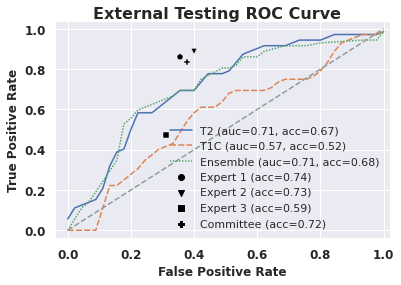

In [52]:
#fig = plot_multiple_precision_recall(train, experts=get_experts_for_names(expert_features, train_set.names))#, comparison_models=get_experts_for_names(comparison_model_features, train_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-train-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_precision_recall(validation, experts=get_experts_for_names(expert_features, validation_set.names))#,  comparison_models=get_experts_for_names(comparison_model_features, validation_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-validation-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_precision_recall(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_precision_recall(test_1, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-1-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_precision_recall(test_2, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-2-precision-recall.svg", bbox_inches = "tight")
#fig = plot_multiple_roc_curve(train, experts=get_experts_for_names(expert_features, train_set.names))#, comparison_models=get_experts_for_names(comparison_model_features, train_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-train-roc.svg", bbox_inches = "tight")
#fig = plot_multiple_roc_curve(validation, experts=get_experts_for_names(expert_features, validation_set.names))#, comparison_models=get_experts_for_names(comparison_model_features, validation_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-validation-roc.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "committee"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
fig.savefig("figures/combined-test-roc.svg", bbox_inches = "tight")

fig = plot_multiple_roc_curve(external)
fig.savefig("figures/combined-external-roc.svg", bbox_inches = "tight")
#fig = plot_multiple_roc_curve(test_2, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))
#fig.savefig("figures/combined-test-2-roc.svg", bbox_inches = "tight")

In [43]:
def correct_num_for_modality(dataset, experts=[], comparison_models=[]): 
    results = list()
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
            total = len(labels)
            results.append({ 
                "correct": correct, 
                "total": total, 
                "incorrect": total-correct, 
                "modality": "Expert {}".format(i),
                "acc": correct/total,                
                "wald": adjusted_wald(correct/total, total),
                **calculate_confusion_matrix_stats_predictions(labels, predictions),
            })
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        total = len(labels)
        correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
        results.append({ 
            "correct": correct, 
            "total": total, 
            "incorrect": total-correct, 
            "modality": MODALITY_KEY[modality],
            "acc": correct/total,
            "wald": adjusted_wald(correct/total, total),
            **calculate_confusion_matrix_stats_predictions(labels, predictions),            
        })        
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = dataset["t1-labels"]
        predictions = [p > 0.5 for p in probabilities]
        predictions = dataset["{}-predictions".format(modality)]
        total = len(labels)
        correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
        results.append({ 
            "correct": correct, 
            "total": total, 
            "incorrect": total-correct, 
            "modality": modality,
            "acc": correct/total,
            "wald": adjusted_wald(correct/total, total),
            **calculate_confusion_matrix_stats_predictions(labels, predictions),            
        })                
    return results

In [45]:
results = correct_num_for_modality(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2"]))#, comparison_models=get_experts_for_names(comparison_model_features, test_set.names, experts=['radiomics'], transform=float))

In [95]:
experts = get_experts_for_names(expert_features, test_set.names, experts=["committee"])

In [96]:
kappa_scores = list()
for e in experts: 
    current = list()
    for x in experts: 
        current.append(cohen_kappa_score(e, x))
    kappa_scores.append(current)
kappa_scores

[[1.0, 0.6627565982404693], [0.6627565982404693, 1.0]]

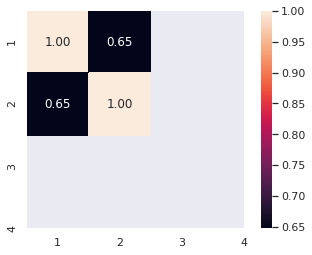

In [48]:
seaborn.heatmap(kappa_scores, annot=True, square=True, fmt=".2f", xticklabels=["1", "2", "3", "4"], yticklabels=["1", "2", "3", "4"])

In [49]:
from itertools import combinations
import numpy as np

In [50]:
unique_kappa = list()
for x, y in combinations(experts, 2): 
    unique_kappa.append(cohen_kappa_score(x, y))
np.average(unique_kappa)

0.6476868327402135

In [51]:
def fleiss_kappa(ratings, n):
    '''
    Computes the Fleiss' kappa measure for assessing the reliability of 
    agreement between a fixed number n of raters when assigning categorical
    ratings to a number of items.
    
    Args:
        ratings: a list of (item, category)-ratings
        n: number of raters
        k: number of categories
    Returns:
        the Fleiss' kappa score
    
    See also:
        http://en.wikipedia.org/wiki/Fleiss'_kappa
    '''
    items = set()
    categories = set()
    n_ij = {}
    
    for i, c in ratings:
        items.add(i)
        categories.add(c)
        n_ij[(i,c)] = n_ij.get((i,c), 0) + 1
    
    N = len(items)
    
    p_j = dict(((c, sum(n_ij.get((i, c), 0) for i in items) / (1.0 * n * N)) for c in categories))
    P_i = dict(((i, (sum(n_ij.get((i, c), 0) ** 2 for c in categories) - n) / (n * (n - 1.0))) for i in items))

    P_bar = sum(P_i.values()) / (1.0 * N)
    P_e_bar = sum(value ** 2 for value in p_j.values())
    
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    
    return kappa

In [52]:
fleiss_kappa_array = list()
for e in list(zip(*experts)): 
    for i in e: 
        fleiss_kappa_array.append((1, i))

In [53]:
fleiss_kappa(fleiss_kappa_array, 4)

-0.33333333333333326

In [54]:
ratings = [(1, 'yes')] * 10 + [(1, 'no')] * 0  + \
[(2, 'yes')] * 8  + [(2, 'no')] * 2  + \
[(3, 'yes')] * 9  + [(3, 'no')] * 1  + \
[(4, 'yes')] * 0  + [(4, 'no')] * 10 + \
[(5, 'yes')] * 7  + [(5, 'no')] * 3
ratings

[(1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (1, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'yes'),
 (2, 'no'),
 (2, 'no'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'yes'),
 (3, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (4, 'no'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'yes'),
 (5, 'no'),
 (5, 'no'),
 (5, 'no')]

In [55]:
x = np.array(experts).T
fleiss_kappa(x)

TypeError: fleiss_kappa() missing 1 required positional argument: 'n'

In [ ]:
ensemble = results.pop()
for r in results: 
    print(r["modality"], fisher_exact([[ensemble["correct"], r["correct"]], [ensemble["incorrect"], r["incorrect"]]]))

In [ ]:
results

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')